In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import os
import sys
import time

from sklearn.preprocessing import MinMaxScaler

!pip install neurodsp
!pip install seaborn

import numpy as np
import scipy.signal as signal
import matplotlib.pyplot as plt

import seaborn as sns

# Import function for Morlet Wavelets
from neurodsp.timefrequency.wavelets import compute_wavelet_transform
from neurodsp.plts import plot_time_series, plot_timefrequency

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.7/149.7 kB 2.7 MB/s eta 0:00:00


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Get the current working directory (where your notebook is)
current_directory = os.getcwd()

# Construct the full path to your data_utils.py file
data_utils_path = '/content/drive/MyDrive/Colab Notebooks/Bachelor Thesis/Thesis Files/data_utils.py'  # Replace with the actual path

# Add the directory containing data_utils.py to the Python path
sys.path.append(os.path.dirname(data_utils_path))  # Add parent directory of data_utils.py


# Now you can import the custom module
import data_utils as du

sys.path = []

In [ ]:
# ONLY FOR RELOAD!

# Reloads if the data_utils has been updated during runtime
# Always need to add and reset the paths
import importlib

# Add the directory containing data_utils.py to the Python path
sys.path.append(os.path.dirname(data_utils_path))  # Add parent directory of data_utils.py

importlib.reload(du)  # This reloads the module

sys.path = []

In [4]:
basePath = "/content/drive/MyDrive/Colab Notebooks/Bachelor Thesis/Data/"

In [7]:
base_path = "/content/drive/MyDrive/Colab Notebooks/Bachelor Thesis/Data/"

data_path = f"{base_path}5_class_test_burst_vec.npy"
label_path = f"{base_path}5_class_test_label_vec.npy"

data_vec_small, label_vec_small = du.load_data(data_path, label_path)

In [16]:
burstPath = f"{basePath}5_class_mid_noise_30s_burst_vec.npy" # 5 noise dim (-8,-4,0,4,8)
labelPath = f"{basePath}5_class_mid_noise_30s_label_vec.npy"

burst_vec, burst_label_vec = du.load_data(burstPath, labelPath)

In [17]:
 # If you see a discrepancy, between No off.. and the shown dict,
 # it means, that a specific unknown subset has been used
 # TODO: Make clear what has been used
du.data_info(burst_vec)


DATASET INFO:
Shape: (10, 20, 5, 7500)

No of Samples: 10

No of Frequencies: 20
Freqency values: [np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(8), np.int64(9), np.int64(11), np.int64(13), np.int64(16), np.int64(18), np.int64(22), np.int64(26), np.int64(31), np.int64(36), np.int64(43), np.int64(51), np.int64(60), np.int64(71), np.int64(84), np.int64(100)]

No of noise ratios: 5
Signal to Noise ratios (in db) [np.int64(-10), np.int64(-8), np.int64(-6), np.int64(-4), np.int64(-2), np.int64(0), np.int64(2), np.int64(4), np.int64(6), np.int64(8)]

No of Datapoints: 7500
No of Features per Datapoint: 1 



In [18]:
mean_freqs = np.logspace(np.log10(4), np.log10(100), num=20)
mean_freqs_round = np.round(mean_freqs).astype(int)
mean_freqs_manual = [4, 5, 5.5, 6, 7, 8, 9, 10, 11, 12, 14, 16, 18, 22, 26, 35, 45, 60, 80, 100]

snr_range = np.arange(-8, 9, 4)

print(snr_range)
print(mean_freqs_round)
print(mean_freqs_manual)

[-8 -4  0  4  8]
[  4   5   6   7   8   9  11  13  16  18  22  26  31  36  43  51  60  71
  84 100]
[4, 5, 5.5, 6, 7, 8, 9, 10, 11, 12, 14, 16, 18, 22, 26, 35, 45, 60, 80, 100]


In [19]:
# Map classes to their representative frequency ranges
label_map_5class = {'n': 0, 't': 1, 'a': 2, 'b': 3, 'g': 4}
old_label_map_binary = {'n': 0, 't': 1, 'a': 1, 'b': 1, 'g': 1}
label_map_binary = {0: 0, 1: 1, 2: 1, 3: 1, 4: 1}

# Vectorized replacement function
def replace_values(arr, mapping):
    """
    Replace values in a NumPy array based on a dictionary mapping.

    Parameters:
        arr (np.ndarray): The input array.
        mapping (dict): The mapping {old_value: new_value}.

    Returns:
        np.ndarray: A new array with replaced values.
    """
    # Create a copy to avoid modifying the original array
    new_arr = arr.copy()

    # Replace each value based on the mapping
    for old_val, new_val in mapping.items():
        new_arr[arr == old_val] = new_val  # Boolean masking to find and replace

    # Without this step, all values would be strings and not integers '1' vs 1
    int_array = new_arr.astype(int)

    return int_array

In [21]:
# Apply the replacement
label_vec_5class = replace_values(burst_label_vec, label_map_5class)
label_vec_binary = replace_values(burst_label_vec, label_map_binary)

In [22]:
# Test: Print part of the updated data
print("Original values:", burst_label_vec[0, 11, 0, 100:140])
print("5 classes values:", label_vec_5class[0, 11, 0, 100:140])
print("Binary classes values:", label_vec_binary[0, 11, 0, 100:140])

Original values: [3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3.
 3. 3. 3. 3. 3. 3. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
5 classes values: [3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 0 0 0 0 0 0 0
 0 0 0]
Binary classes values: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0
 0 0 0]


In [24]:
n_samples = 1  # Choose the 3rd sample (index 2)
burst_range = 9   # Choose the 6th burst interval (index 5)
x_datapoints = 15000 # 15000 datapoints aka 60s of data. 10s is enough to display everything

specific_label_5class_data = label_vec_5class[:n_samples, :, :, :x_datapoints]
specific_label_binary_data = label_vec_binary[:n_samples, :, :, :x_datapoints]
specific_signal_data = burst_vec[:n_samples, :, :, :x_datapoints]

print(specific_label_5class_data.shape)
print(specific_label_binary_data.shape)
print(specific_signal_data.shape)

(1, 20, 5, 7500)
(1, 20, 5, 7500)
(1, 20, 5, 7500)


In [25]:
## Class distribution
unique, counts = np.unique(specific_label_5class_data.flatten(), return_counts=True)
print(f"Class distribution: {dict(zip(unique, counts))}")
print(f"Noise  Percentage: {(counts[0]/(sum(counts))):.4f}")
print(f"Theta Percentage: {(counts[1]/(sum(counts))):.4f}")
print(f"Alpha Percentage: {(counts[2]/(sum(counts))):.4f}")
print(f"Beta Percentage: {(counts[3]/(sum(counts))):.4f}")
print(f"Gamma Percentage: {(counts[4]/(sum(counts))):.4f}")

Class distribution: {np.int64(0): np.int64(400530), np.int64(1): np.int64(88112), np.int64(2): np.int64(88779), np.int64(3): np.int64(88323), np.int64(4): np.int64(84256)}
Noise  Percentage: 0.5340
Theta Percentage: 0.1175
Alpha Percentage: 0.1184
Beta Percentage: 0.1178
Gamma Percentage: 0.1123


In [26]:
## Binary Class distribution
unique, counts = np.unique(specific_label_binary_data.flatten(), return_counts=True)
print(f"Class distribution: {dict(zip(unique, counts))}")
print(f"Noise  Percentage: {(counts[0]/(sum(counts))):.4f}")
print(f"Burst Percentage: {(counts[1]/(sum(counts))):.4f}")

Class distribution: {np.int64(0): np.int64(400530), np.int64(1): np.int64(349470)}
Noise  Percentage: 0.5340
Burst Percentage: 0.4660


### BOSC Implementation

In [ ]:
import numpy as np
import scipy.signal as signal
from scipy.stats import chi2
from scipy.ndimage import label

def morlet_wavelet_transform(signal, fs, freqs, width=6):
    """
    Computes the Morlet Wavelet Transform of a signal.

    Parameters:
    - signal: np.array, time-series data (e.g., length 15000 for 60s at 250 Hz)
    - fs: int, sampling frequency (e.g., 250 Hz)
    - freqs: np.array, frequencies to decompose the signal into
    - width: float, wavelet width parameter (default: 6 cycles)

    Returns:
    - power_spectrum: np.array, power spectrum [frequencies x time points]
    """
    power_spectrum = np.zeros((len(freqs), len(signal)))

    for i, freq in enumerate(freqs):
        # Calculate the wavelet
        sigma_t = width / (2 * np.pi * freq)
        time = np.arange(-3.5 * sigma_t, 3.5 * sigma_t, 1/fs)
        wavelet = np.exp(2j * np.pi * freq * time) * np.exp(-time**2 / (2 * sigma_t**2))

        # Convolve the wavelet with the signal
        conv_result = np.convolve(signal, wavelet, mode='same')

        # Power spectrum is the squared magnitude of the convolution
        power_spectrum[i, :] = np.abs(conv_result) ** 2

    return power_spectrum

def background_spectrum_fit(power_spectrum, freqs):
    """
    Fits the background spectrum using linear regression in log-log space.

    Parameters:
    - power_spectrum: np.array, power spectrum [frequencies x time points]
    - freqs: np.array, frequencies of the power spectrum

    Returns:
    - background_fit: np.array, estimated background power for each frequency
    """
    mean_power = np.mean(power_spectrum, axis=1)
    log_freqs = np.log10(freqs)
    log_power = np.log10(mean_power)

    # Linear regression in log-log space
    slope, intercept = np.polyfit(log_freqs, log_power, 1)
    background_fit = 10 ** (intercept + slope * log_freqs)

    return background_fit

def compute_power_threshold(background_fit, percentile=95):
    """
    Computes the power threshold using the 95th percentile of the chi-square distribution.

    Parameters:
    - background_fit: np.array, estimated background power for each frequency
    - percentile: float, percentile for thresholding (default: 95)

    Returns:
    - power_threshold: np.array, power threshold for each frequency
    """
    threshold = chi2.ppf(percentile / 100.0, df=2) * background_fit
    return threshold

def duration_threshold(freqs, min_cycles=3, fs=250):
    """
    Computes the minimum duration threshold for each frequency.

    Parameters:
    - freqs: np.array, frequencies of the power spectrum
    - min_cycles: int, minimum number of cycles for a burst (default: 3)
    - fs: int, sampling frequency (e.g., 250 Hz)

    Returns:
    - duration_thresholds: np.array, minimum duration in samples for each frequency
    """
    min_duration = min_cycles / freqs  # In seconds
    min_samples = (min_duration * fs).astype(int)
    return min_samples

def bosc(signal, fs, freq_range=(4, 100), width=6, percentile=95, min_cycles=3):
    """
    BOSC method for detecting oscillatory bursts in a frequency range.

    Parameters:
    - signal: np.array, time-series data (e.g., length 15000 for 60s at 250 Hz)
    - fs: int, sampling frequency (e.g., 250 Hz)
    - freq_range: tuple, frequency range for analysis (e.g., (4, 100))
    - width: float, wavelet width parameter (default: 6 cycles)
    - percentile: float, percentile for power thresholding (default: 95)
    - min_cycles: int, minimum number of cycles for a burst (default: 3)

    Returns:
    - labels: np.array, binary labels of bursts (1 for burst, 0 for no burst)
    """
    # Frequency Range and Logarithmic Frequency Scale
    freqs = np.logspace(np.log10(freq_range[0]), np.log10(freq_range[1]), num=30)

    # Step 1: Compute Wavelet Power Spectrum
    power_spectrum = morlet_wavelet_transform(signal, fs, freqs, width=width)

    # Step 2: Estimate Background Spectrum
    background_fit = background_spectrum_fit(power_spectrum, freqs)

    # Step 3: Compute Power Thresholds
    power_thresholds = compute_power_threshold(background_fit, percentile=percentile)

    # Step 4: Compute Duration Thresholds
    duration_thresholds = duration_threshold(freqs, min_cycles=min_cycles, fs=fs)

    # Step 5: Detect Bursts
    labels = np.zeros(len(signal), dtype=int)
    for i, freq in enumerate(freqs):
        # Find where power exceeds the threshold
        above_threshold = power_spectrum[i, :] > power_thresholds[i]

        # Label continuous bursts
        burst_labels, num_bursts = label(above_threshold)

        for j in range(1, num_bursts+1):
            burst_indices = np.where(burst_labels == j)[0]
            # Check if duration exceeds threshold
            if len(burst_indices) >= duration_thresholds[i]:
                labels[burst_indices] = 1

    return labels

# Example usage
fs = 250  # Sampling frequency
signal = np.random.randn(15000)  # Replace with actual neural data

# Detect bursts in the 4-100 Hz range
labels_bosc = bosc(signal, fs, freq_range=(4, 100))

labels_bosc[:10]


array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [ ]:
def bosc_multiclass(signal, fs, freq_bands=[(4, 8), (8, 12), (13, 30), (30, 100)], width=6, percentile=95, min_cycles=3):
    """
    Multi-class BOSC method for detecting oscillatory bursts across multiple frequency bands.

    Parameters:
    - signal: np.array, time-series data (e.g., length 15000 for 60s at 250 Hz)
    - fs: int, sampling frequency (e.g., 250 Hz)
    - freq_bands: list of tuples, frequency bands for analysis
                   (e.g., [(4, 8), (8, 12), (13, 30), (30, 100)] for Theta, Alpha, Beta, Gamma)
    - width: float, wavelet width parameter (default: 6 cycles)
    - percentile: float, percentile for power thresholding (default: 95)
    - min_cycles: int, minimum number of cycles for a burst (default: 3)

    Returns:
    - labels: np.array, multi-class labels of bursts (0 for no burst, 1 for Theta, 2 for Alpha, 3 for Beta, 4 for Gamma)
    """
    # Initialize label array
    labels = np.zeros(len(signal), dtype=int)

    # Iterate over frequency bands
    for band_idx, (low, high) in enumerate(freq_bands, start=1):
        # Frequency Range and Logarithmic Frequency Scale
        freqs = np.logspace(np.log10(low), np.log10(high), num=10)

        # Step 1: Compute Wavelet Power Spectrum
        power_spectrum = morlet_wavelet_transform(signal, fs, freqs, width=width)

        # Step 2: Estimate Background Spectrum
        background_fit = background_spectrum_fit(power_spectrum, freqs)

        # Step 3: Compute Power Thresholds
        power_thresholds = compute_power_threshold(background_fit, percentile=percentile)

        # Step 4: Compute Duration Thresholds
        duration_thresholds = duration_threshold(freqs, min_cycles=min_cycles, fs=fs)

        # Step 5: Detect Bursts
        for i, freq in enumerate(freqs):
            # Find where power exceeds the threshold
            above_threshold = power_spectrum[i, :] > power_thresholds[i]

            # Label continuous bursts
            burst_labels, num_bursts = label(above_threshold)

            for j in range(1, num_bursts+1):
                burst_indices = np.where(burst_labels == j)[0]
                # Check if duration exceeds threshold
                if len(burst_indices) >= duration_thresholds[i]:
                    # Assign label if this band is dominant
                    labels[burst_indices] = np.maximum(labels[burst_indices], band_idx)

    return labels

# Example usage
fs = 250  # Sampling frequency
signal = np.random.randn(15000)  # Replace with actual neural data

# Multi-class BOSC with labels for Theta, Alpha, Beta, and Gamma
freq_bands = [(4, 8), (8, 12), (13, 30), (30, 100)]
labels_multiclass = bosc_multiclass(signal, fs, freq_bands=freq_bands)

labels_multiclass[:10]


array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

## Feature Functions


In [48]:
from scipy.signal import hilbert
from scipy.signal import butter, filtfilt, firwin
import scipy.signal as signal
import time


def butter_bandpass_filter(data, lowcut, highcut, fs, order=4):
    """
    Applies a Butterworth bandpass filter to the signal data.

    Args:
        data (np.ndarray): The input signal.
        lowcut (float): Lower cutoff frequency in Hz.
        highcut (float): Upper cutoff frequency in Hz.
        fs (float): Sampling frequency in Hz.
        order (int, optional): Order of the filter. Defaults to 4.

    Returns:
        np.ndarray: The filtered signal.
    """
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    # Applies a butter bandpass filter
    b, a = butter(order, [low, high], btype='band')
    # Applies digital filter to minimize distortion introduced by the filters.
    y = filtfilt(b, a, data)
    return y

def fir_bandpass(signal_data, lowcut, highcut, fs, numtaps=101, window="hamming"):
    """
    FIR Bandpass Filter (Linear Phase)
    """
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    fir_coeff = firwin(numtaps, [low, high], pass_zero=False, window=window)
    return signal.filtfilt(fir_coeff, 1.0, signal_data)  # Zero-phase FIR filtering

def kaiser_bandpass(signal_data, lowcut, highcut, fs, numtaps=101, beta=12):
    """
    Applies a Kaiser-windowed FIR bandpass filter to a neural signal.

    Args:
        signal_data (np.ndarray): 1D input signal.
        lowcut (float): Lower cutoff frequency (Hz).
        highcut (float): Upper cutoff frequency (Hz).
        fs (float): Sampling frequency (Hz).
        numtaps (int, optional): Number of filter taps (higher = better frequency selectivity). Defaults to 101.
        beta (float, optional): Kaiser window beta parameter (higher = better stopband attenuation). Defaults to 8.

    Returns:
        np.ndarray: Filtered signal.
        np.ndarray: FIR filter coefficients.
    """
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist

    # Design FIR filter using Kaiser window
    fir_coeff = signal.firwin(numtaps, [low, high], pass_zero=False, window=('kaiser', beta))

    # Apply zero-phase filtering (filtfilt prevents phase distortion)
    filtered_signal = signal.filtfilt(fir_coeff, 1.0, signal_data)

    return filtered_signal, fir_coeff

def bartlett_bandpass(signal_data, lowcut, highcut, fs, numtaps=101):
    """
    Applies a Bartlett-windowed FIR bandpass filter to a neural signal.

    Args:
        signal_data (np.ndarray): 1D input signal.
        lowcut (float): Lower cutoff frequency (Hz).
        highcut (float): Upper cutoff frequency (Hz).
        fs (float): Sampling frequency (Hz).
        numtaps (int, optional): Number of filter taps (higher = better frequency selectivity). Defaults to 101.

    Returns:
        np.ndarray: Filtered signal.
        np.ndarray: FIR filter coefficients.
    """
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist

    # Design FIR filter using Bartlett window
    fir_coeff = signal.firwin(numtaps, [low, high], pass_zero=False, window='bartlett')

    # Apply zero-phase filtering (filtfilt prevents phase distortion)
    filtered_signal = signal.filtfilt(fir_coeff, 1.0, signal_data)

    return filtered_signal, fir_coeff

# Step 1: Compute the Hilbert transform amplitude for the signal
def compute_hilbert_features(signal_flat, fs=250, filter_type='butter', **kwargs):
    """
    Computes Hilbert amplitude features with frequency-dependent filter orders and smoothing.

    Args:
        signal_flat (np.ndarray): The input signal.
        fs (int, optional): Sampling frequency. Defaults to 250.
        filter_type (str, optional): Type of bandpass filter to use ('butter' or 'fir'). Defaults to 'butter'.
        **kwargs: Additional keyword arguments to pass to the bandpass filter function.

    Returns:
        np.ndarray: The Hilbert amplitude features.
    """

    # Define frequency bands with filter orders and smoothing factors
    frequency_bands = {
        'theta': (4, 7, 6, 0.0),  # (lowcut, highcut, filter_order, smoothing_factor)
        'alpha': (8, 12, 6, 0.0),
        'beta': (13, 30, 4, 0.0),
        'gamma': (30, 100, 2, 0.15)
    }

    hilbert_features = []

    for band_name, (lowcut, highcut, filter_order, smoothing_factor) in frequency_bands.items():
        # Apply bandpass filter based on filter_type
        if filter_type == 'butter':
            filtered_signal = butter_bandpass_filter(signal_flat, lowcut, highcut, fs, order=filter_order)
        elif filter_type == 'fir':
            filtered_signal = fir_bandpass(signal_flat, lowcut, highcut, fs, **kwargs)  # Pass kwargs to fir_bandpass
        elif filter_type == 'kaiser':
            filtered_signal, _ = kaiser_bandpass(signal_flat, lowcut, highcut, fs, **kwargs)  # Pass kwargs to kaiser_bandpass, ignore coefficients
        elif filter_type == 'barlett':
            filtered_signal, _ = bartlett_bandpass(signal_flat, lowcut, highcut, fs, **kwargs)  # Pass kwargs to kaiser_bandpass, ignore coefficients
        else:
            raise ValueError("Invalid filter_type. Choose 'butter' or 'fir'.")

        # Compute Hilbert amplitude envelope
        amplitude_envelope = np.abs(hilbert(filtered_signal))

        # Apply smoothing (e.g., moving average)
        window_size = int(smoothing_factor * fs)  # Adjust window size based on frequency and smoothing factor
        if window_size > 0:  # Apply smoothing only if window size is greater than 0
            amplitude_envelope = np.convolve(amplitude_envelope, np.ones(window_size) / window_size, mode='same')


        hilbert_features.append(amplitude_envelope)

    hilbert_features = np.array(hilbert_features) ** 2

    return np.column_stack(hilbert_features)


# Step 2: Generate CWT Features (Continuous Wavelet Transform)
# This generates many features at the same time, I will only keep the most promissing one
def generate_cwt_features_single(signal, scales, fs=250):
    """
    Generate CWT features for a single 1D signal.
    Args:
        signal: 1D array of time-series data.
        scales: Range of scales for the CWT.
        fs: sampling frequency (e.g., 'cmor').
    Returns:
        2D array of CWT coefficients (time_steps, scales).
    """
    mwt = compute_wavelet_transform(signal, fs = fs, freqs = scales, n_cycles=7, scaling=0.5)

    # Transpose to (time_steps, scales)
    # and turn values into normal floats instead of imaginary numbers
    # Converting them into with absolutes maintains the signals magnitude values
    # abs: Magnitude = root(real^2 + imaginary^2)
    return np.abs(mwt).T ** 2

### Testing different Filters


In [14]:
label_vec_small.shape

(5, 4, 500)

In [51]:
noise = 3
freq = 18

label_sample = specific_label_5class_data[0, freq, noise, :].flatten()
signal_sample = specific_signal_data[0, freq, noise, :].flatten()

hilbert_features = compute_hilbert_features(signal_sample)
hilbert_features_fir = compute_hilbert_features(signal_sample, filter_type='kaiser', numtaps=101)
hilbert_features_kaiser = compute_hilbert_features(signal_sample, filter_type='barlett', numtaps=101)
# wavelet_features = generate_cwt_features_single(signal_sample, mean_freqs_round)

Frequency Present: 80Hz


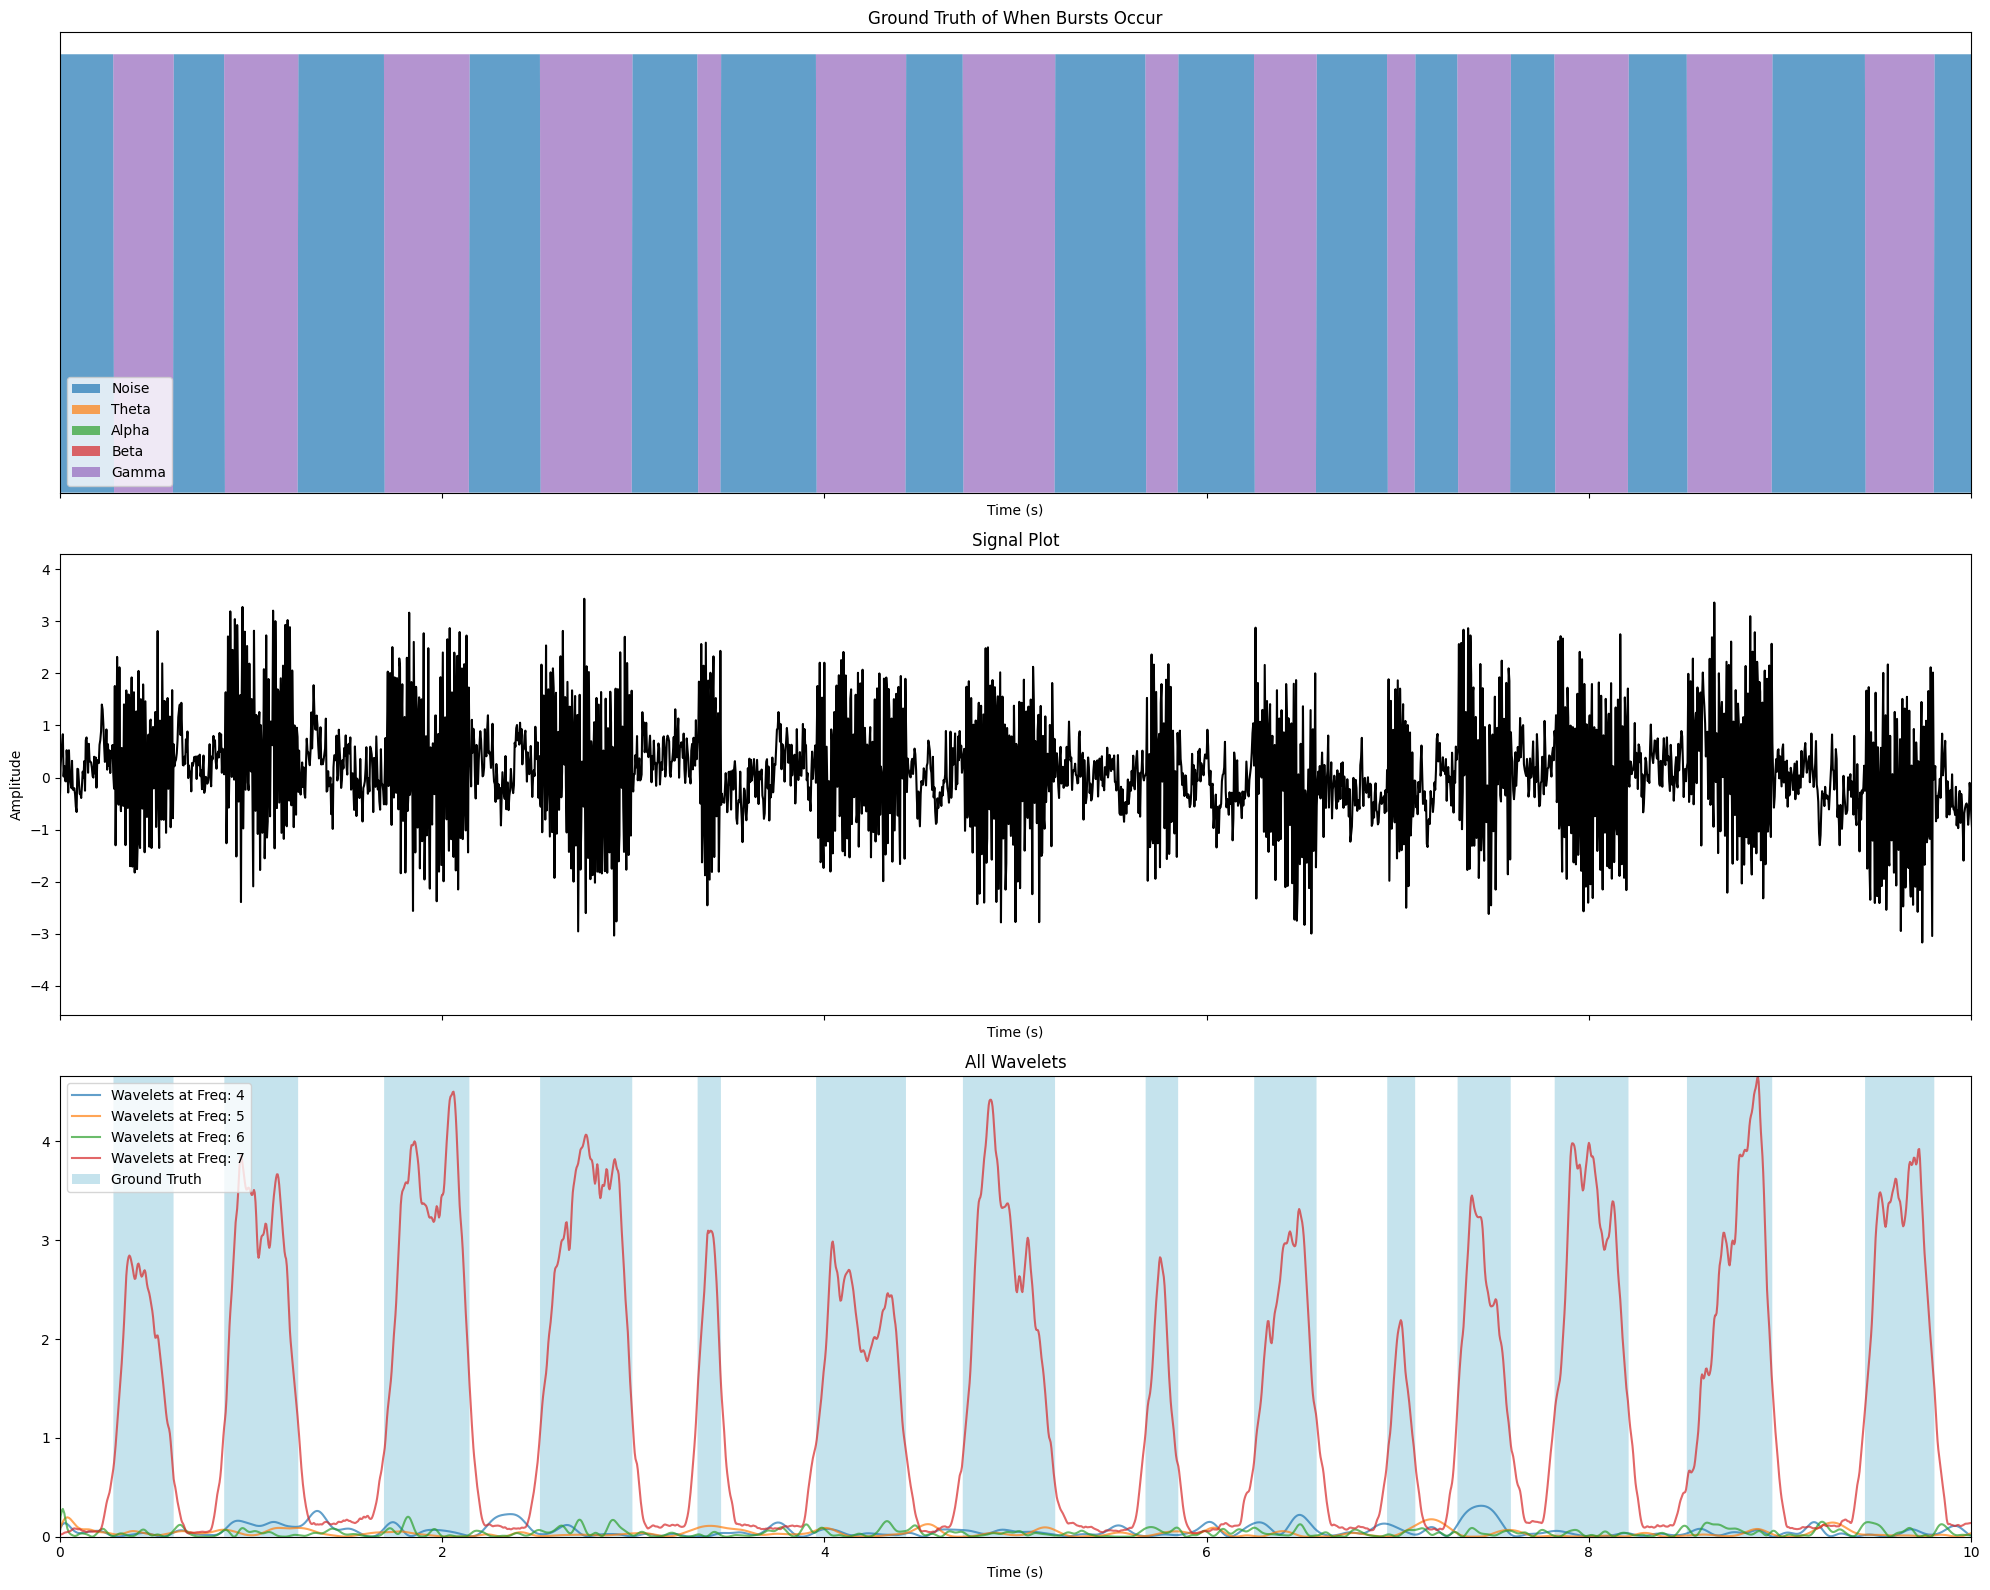

In [52]:
print(f"Frequency Present: {mean_freqs_manual[freq]}Hz")
du.visualize_feature_data(label_sample, signal_sample, hilbert_features_fir,
                          sampling_frequency=250, duration=30,
                          time_window=(0, 10), category_labels=["Noise","Theta","Alpha","Beta","Gamma"])

# du.visualize_feature_data(label_sample, signal_sample, wavelet_features[:,0:4],
#                           sampling_frequency=250, duration=30,
#                           time_window=(0, 10), category_labels=["Noise", "Theta","Alpha","Beta","Gamma"])



## 5 way feature selection and extraction

Hilbert Amplitude

Correlation Metric:
- Pearson for ordinal relationship
- ANOVA F-test for no order

In [ ]:
# Preping the data

# Reshape to 2D: flatten the first 3 dimensions into one
# Step 1: Flatten both arrays into 1D arrays
signal_flat = specific_signal_data.flatten()  # Shape: (1 * 20 * 10 * 15000,) -> (3000000,)
label_flat_5 = specific_label_5class_data.flatten()    # Shape: (1 * 20 * 10 * 15000,) -> (3000000,)

# Step 2: Stack them together as columns in a 2D array
combined_data = np.column_stack((label_flat_5, signal_flat))  # Shape: (3000000, 2)

combined_data.shape

(7500000, 2)

### Compute Butter Hilbert amplitude

In [ ]:
import time

start_time = time.time()  # Record start time
hilbert_features = compute_hilbert_features(signal_flat)


end_time = time.time()  # Record end time
execution_time = end_time - start_time  # Calculate total time

print(f"Hilbert feature calculation time: {execution_time:.3f} seconds")

# Step 3: Combine signal, label, and Hilbert amplitude into a single 2D array
combined_data = np.column_stack((label_flat_5, signal_flat, hilbert_features))  # Shape: (30000000, 6)
combined_data.shape

Hilbert feature calculation time: 13.160 seconds


(7500000, 6)

### Compute FIR Hilbert

In [ ]:
# import time

# start_time = time.time()  # Record start time

# hilbert_features_fir = compute_hilbert_features(signal_flat, filter_type='fir', numtaps=101, window='blackman')

# end_time = time.time()  # Record end time
# execution_time = end_time - start_time  # Calculate total time

# print(f"Hilbert feature calculation time: {execution_time:.3f} seconds")

# combined_data = np.hstack((combined_data, hilbert_features_fir))  # Shape: (30000000, 6)
# combined_data.shape

Hilbert feature calculation time: 8.180 seconds


(7500000, 10)

### Compute Kaiser FIR Hilbert

In [ ]:
import time

start_time = time.time()  # Record start time

hilbert_features_fir = compute_hilbert_features(signal_flat, filter_type='kaiser', numtaps=101, beta=12)

end_time = time.time()  # Record end time
execution_time = end_time - start_time  # Calculate total time

print(f"Hilbert feature calculation time: {execution_time:.3f} seconds")

combined_data = np.hstack((combined_data, hilbert_features_fir))  # Shape: (30000000, 6)
combined_data.shape

Hilbert feature calculation time: 11.971 seconds


(7500000, 10)

### Barlett FIR Hilbert

In [ ]:
import time

start_time = time.time()  # Record start time

hilbert_features_fir = compute_hilbert_features(signal_flat, filter_type='barlett', numtaps=101)

end_time = time.time()  # Record end time
execution_time = end_time - start_time  # Calculate total time

print(f"Hilbert feature calculation time: {execution_time:.3f} seconds")

combined_data = np.hstack((combined_data, hilbert_features_fir))  # Shape: (30000000, 6)
combined_data.shape

Hilbert feature calculation time: 8.402 seconds


(7500000, 14)

### Compute Wavelets

In [ ]:
start_time = time.time()

freqs_wavelets = mean_freqs_round.copy()

# Assuming data is the raw signal dataset (samples, time_steps)
cwt_features = generate_cwt_features_single(signal_flat, freqs_wavelets)

end_time = time.time()
wavelet_time = end_time - start_time
print(f"Wavelet calculation time: {wavelet_time:.3f} seconds")

cwt_features.shape

Wavelet calculation time: 20.167 seconds


(7500000, 20)

In [ ]:
combined_data_extended = np.hstack((combined_data, cwt_features))

In [ ]:
combined_data_extended.shape

(7500000, 34)

### Correlation Metrics and visualizations

In [ ]:
from scipy.stats import pearsonr
from scipy.stats import f_oneway
from sklearn.preprocessing import MinMaxScaler


features_only = combined_data_extended[:, 1:]
labels_only = combined_data_extended[:, 0].astype(int)

# Assuming 'features' is your feature matrix
scaler = MinMaxScaler(feature_range=(-1, 1))
scaled_features = scaler.fit_transform(features_only)

def pearson_correlation_metrics(features, labels):
    # Compute Pearson correlation for each feature with the labels
    p_correlations = {}

    for i in range(features.shape[1]):
        feature_values = features[:, i].flatten()

        # Calculate Pearson correlation
        corr, _ = pearsonr(feature_values, labels)
        p_correlations[f"Feature {i+1}"] = corr

    # Sort features by absolute correlation values
    sorted_correlations = sorted(p_correlations.items(), key=lambda x: abs(x[1]), reverse=True)

    print("Pearson Correlations")
    for feature, corr in sorted_correlations:
        print(f"Feature: {feature}, Correlation: {corr}")

# pearson_correlation_metrics(scaled_features, labels_only)

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def feature_category_correlation(feature_data, label_data, category_names):
    """
    Calculates the correlation between features and categories and displays it in a table.

    Args:
        feature_data (np.ndarray): Feature data of shape (N, F) where N is the number of samples and F is the number of features.
        label_data (np.ndarray): Label data of shape (N, 5) where 5 represents the 5 categories.
        category_names (list): List of category names (e.g., ['Noise', 'Theta', 'Alpha', 'Beta', 'Gamma']).

    Returns:
        pd.DataFrame: A Pandas DataFrame containing the correlation matrix.
    """
    # Reshape label_data to 2D if it has more than 2 dimensions
    label_data = label_data.reshape(-1, label_data.shape[-1])
    # Reshape feature_data to 2D to match label_data
    feature_data = feature_data.reshape(-1, feature_data.shape[-1])

    num_features = feature_data.shape[1]
    num_categories = label_data.shape[1]

    correlation_matrix = np.zeros((num_features, num_categories))

    for feature_idx in range(num_features):
        for category_idx in range(num_categories):
            correlation_matrix[feature_idx, category_idx] = np.corrcoef(
                feature_data[:, feature_idx], label_data[:, category_idx]
            )[0, 1]  # Get the correlation coefficient

    # Create a Pandas DataFrame for the table
    correlation_df = pd.DataFrame(correlation_matrix,
                                  index=[f"Feature {i}" for i in range(num_features)],
                                  columns=category_names)
    return correlation_df

# Example usage:
category_names = ['Noise', 'Theta', 'Alpha', 'Beta', 'Gamma']

label_sample_vec = labels_only.flatten()

label_sample_vec = du.one_hot_encode_single_sample(label_sample_vec, categories=[0,1,2,3,4])
correlation_table = feature_category_correlation(features_only, label_sample_vec, category_names)

In [ ]:
correlation_table.shape

(33, 5)

In [ ]:
# Create custom y-axis labels
feature_names = ['Input Signal'] + \
                [f'Butter {freq}' for freq in category_names[1:]] + \
                [f'Kaiser {freq}' for freq in category_names[1:]] + \
                [f'Barlett {freq}' for freq in category_names[1:]] + \
                [f'Wavelet at {freq} Hz' for freq in mean_freqs_round]

print(feature_names)

feature_names = ['Input Signal'] + \
                [f'{filter_type} {freq_band}' for freq_band in category_names[1:]
                 for filter_type in ['Butter', 'Kaiser', 'Barlett']] + \
                [f'Wavelet at {freq} Hz' for freq in mean_freqs_round]

print(len(feature_names))

# Get the indices for reordering
num_freq_bands = len(category_names) - 1  # Number of freq bands (excluding Noise)
num_filter_types = 3  # Butter, Kaiser, Barlett
base_index = 1  # Start after 'Input Signal'

reorder_indices = [0]  # Keep 'Input Signal' at the beginning
for freq_idx in range(num_freq_bands):
    for filter_idx in range(num_filter_types):
        reorder_indices.append(base_index + freq_idx + filter_idx * num_freq_bands)
reorder_indices.extend(list(range(base_index + num_freq_bands * num_filter_types, correlation_table.shape[0])))

print(reorder_indices)

# Reorder the correlation table rows
correlation_table = correlation_table.iloc[reorder_indices]
correlation_table = correlation_table.reset_index(drop=True)
correlation_table.index = feature_names
print(feature_names)

['Input Signal', 'Butter Theta', 'Butter Alpha', 'Butter Beta', 'Butter Gamma', 'Kaiser Theta', 'Kaiser Alpha', 'Kaiser Beta', 'Kaiser Gamma', 'Barlett Theta', 'Barlett Alpha', 'Barlett Beta', 'Barlett Gamma', 'Wavelet at 4 Hz', 'Wavelet at 5 Hz', 'Wavelet at 6 Hz', 'Wavelet at 7 Hz', 'Wavelet at 8 Hz', 'Wavelet at 9 Hz', 'Wavelet at 11 Hz', 'Wavelet at 13 Hz', 'Wavelet at 16 Hz', 'Wavelet at 18 Hz', 'Wavelet at 22 Hz', 'Wavelet at 26 Hz', 'Wavelet at 31 Hz', 'Wavelet at 36 Hz', 'Wavelet at 43 Hz', 'Wavelet at 51 Hz', 'Wavelet at 60 Hz', 'Wavelet at 71 Hz', 'Wavelet at 84 Hz', 'Wavelet at 100 Hz']
33
[0, 1, 5, 9, 2, 6, 10, 3, 7, 11, 4, 8, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32]
['Input Signal', 'Butter Theta', 'Kaiser Theta', 'Barlett Theta', 'Butter Alpha', 'Kaiser Alpha', 'Barlett Alpha', 'Butter Beta', 'Kaiser Beta', 'Barlett Beta', 'Butter Gamma', 'Kaiser Gamma', 'Barlett Gamma', 'Wavelet at 4 Hz', 'Wavelet at 5 Hz', 'Wavelet at 6 Hz', 'W

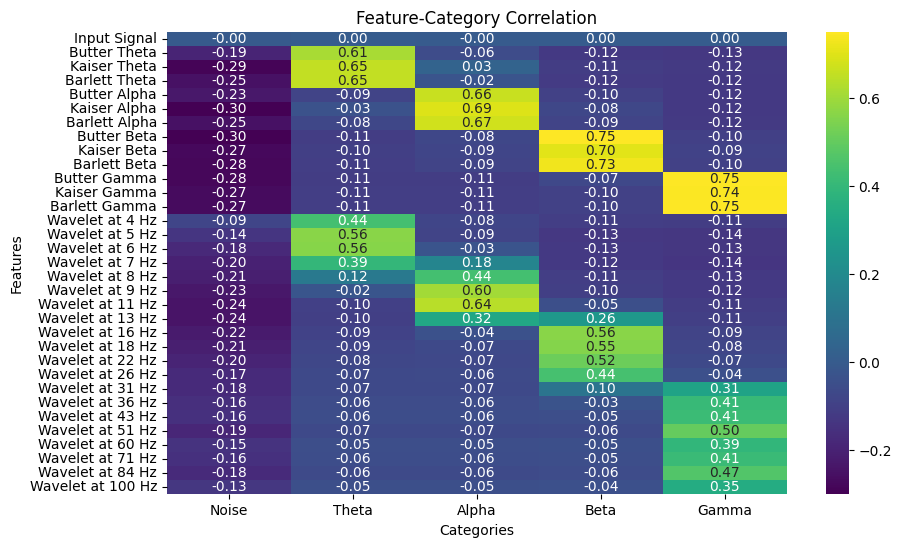

In [ ]:


# Display the correlation table as a heatmap
plt.figure(figsize=(10, 6))  # Adjust figure size as needed
sns.heatmap(correlation_table, annot=True, cmap="viridis", fmt=".2f",
            yticklabels=feature_names)  # Use custom yticklabels
plt.title("Feature-Category Correlation")
plt.xlabel("Categories")
plt.ylabel("Features")
plt.show()

## Quantitative Feature Analysis

In [ ]:
features_only = combined_data_extended[:, 1:]
labels_only = combined_data_extended[:, 0].astype(int)
print(labels_only.shape)
print(features_only.shape)

(7500000,)
(7500000, 33)


In [ ]:
# Assuming features_only and labels_only are already defined
original_shape = (10, 20, 5, 7500, -1)  # Define the target shape

# Reshape features_only
reshaped_features = features_only.reshape(original_shape)

# Reshape labels_only (needs an extra dimension for compatibility)
reshaped_labels = labels_only.reshape(original_shape[:-1])  # (10, 20, 5, 7500, 1)
# labels_only.shape = (10, 20, 5, 7500) which needs to be changed to (10, 20, 5, 7500, 1)

In [ ]:
reshaped_labels.shape

(10, 20, 5, 7500)

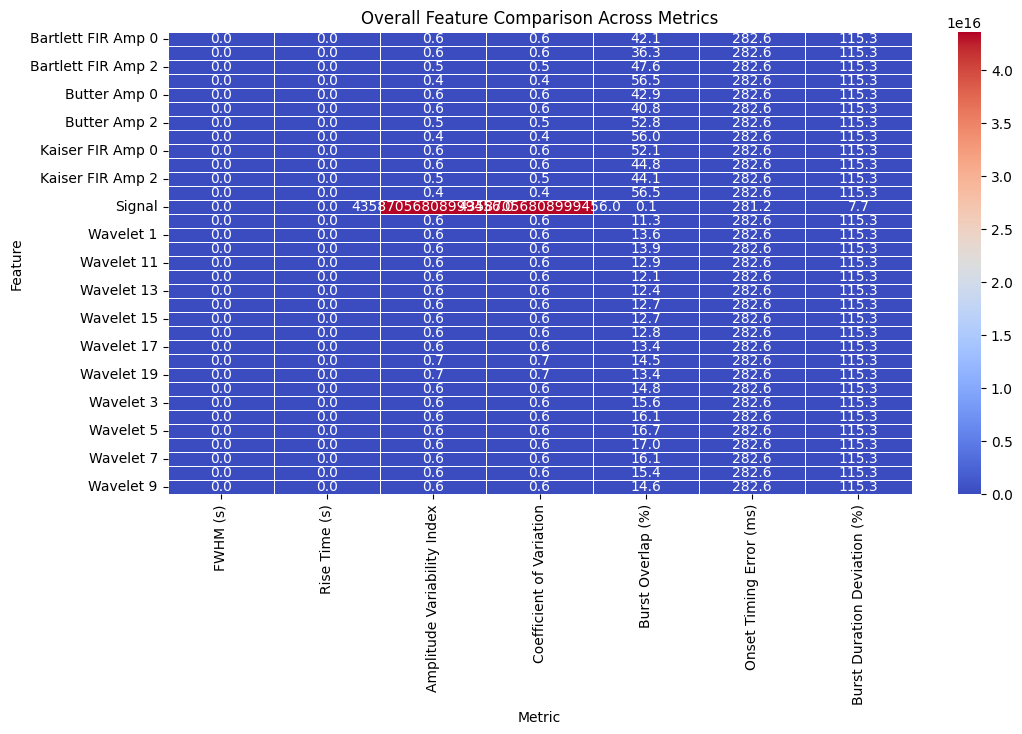

In [ ]:

# Assume dataset shape (10 samples, 20 frequencies, 5 noise levels, 7500 time points, F features)
# Simulating some random data for demonstration (replace with actual data)
num_samples = 10
num_frequencies = 20
num_noise_levels = 5
num_timepoints = 7500  # Assuming time points correspond to the signal duration
num_features = 33  # Wavelet vs Hilbert features

# Simulated dataset (replace with actual data)
data = reshaped_features[:2]

labels = reshaped_labels

# Sampling frequency (Assumption, replace with actual)
fs = 250  # Hz

# Frequency values for wavelets (logarithmically spaced between 4-100 Hz)
frequencies = np.logspace(np.log10(4), np.log10(100), num_frequencies)

# Redefine feature labels
feature_labels = ["Signal"] + \
                 [f"Butter Amp {i}" for i in range(4)] + \
                 [f"Kaiser FIR Amp {i}" for i in range(4)] + \
                 [f"Bartlett FIR Amp {i}" for i in range(4)] + \
                 [f"Wavelet {i}" for i in range(20)]


# Initialize results dictionary
results = {
    "Feature": [], "Frequency (Hz)": [], "FWHM (s)": [], "Rise Time (s)": [],
    "Amplitude Variability Index": [], "Coefficient of Variation": [],
    "Burst Overlap (%)": [], "Onset Timing Error (ms)": [], "Burst Duration Deviation (%)": []
}

# Compute metrics for each feature type
for feat_idx, feature_name in enumerate(feature_labels):
    for freq_idx, freq in enumerate(np.logspace(np.log10(4), np.log10(100), num_frequencies)):
        signal_data = data[0, freq_idx, :, :, feat_idx]  # Ignore noise for now
        ground_truth_burst = labels[0, freq_idx, :, :]  # Ground truth burst labels

        # Compute standard feature extraction metrics
        fwhm = compute_fwhm(signal_data, fs)
        rise_time = compute_rise_time(signal_data, fs)
        avi = compute_amplitude_variability(signal_data)
        cv = compute_coefficient_of_variation(signal_data)

        # Compute ground truth comparison metrics
        burst_overlap = compute_burst_overlap(signal_data, ground_truth_burst)
        onset_error = compute_onset_timing_error(signal_data, ground_truth_burst, fs)
        burst_duration_dev = compute_burst_duration_deviation(signal_data, ground_truth_burst)

        # Store results
        results["Feature"].append(feature_name)
        results["Frequency (Hz)"].append(freq)
        results["FWHM (s)"].append(fwhm)
        results["Rise Time (s)"].append(rise_time)
        results["Amplitude Variability Index"].append(avi)
        results["Coefficient of Variation"].append(cv)
        results["Burst Overlap (%)"].append(burst_overlap)
        results["Onset Timing Error (ms)"].append(onset_error)
        results["Burst Duration Deviation (%)"].append(burst_duration_dev)

# Convert results to DataFrame
df_results = pd.DataFrame(results)

# Simplify analysis: Aggregate metrics per feature without frequency-specific analysis

# Group by feature and compute mean values across all frequencies
df_results_simplified = df_results.groupby("Feature").mean().reset_index()

# Select relevant metrics
metrics = ["FWHM (s)", "Rise Time (s)", "Amplitude Variability Index",
           "Coefficient of Variation", "Burst Overlap (%)",
           "Onset Timing Error (ms)", "Burst Duration Deviation (%)"]

# Generate a single heatmap for overall feature comparison
plt.figure(figsize=(12, 6))
pivot_df = df_results_simplified.set_index("Feature")[metrics]
sns.heatmap(pivot_df, cmap="coolwarm", annot=True, fmt=".1f", linewidths=0.5)
plt.title("Overall Feature Comparison Across Metrics")
plt.xlabel("Metric")
plt.ylabel("Feature")
plt.show()


In [ ]:
df_results_simplified

,Feature,Frequency (Hz),FWHM (s),Rise Time (s),Amplitude Variability Index,Coefficient of Variation,Burst Overlap (%),Onset Timing Error (ms),Burst Duration Deviation (%)
0,Bartlett FIR Amp 0,31.000606,0.0144,0.0056,6.098910e-01,6.098910e-01,42.074760,282.6,115.274939
1,Bartlett FIR Amp 1,31.000606,0.0150,0.0070,5.942850e-01,5.942850e-01,36.269205,282.6,115.274939
2,Bartlett FIR Amp 2,31.000606,0.0144,0.0044,5.302857e-01,5.302857e-01,47.576716,282.6,115.274939
3,Bartlett FIR Amp 3,31.000606,0.0132,0.0030,3.936516e-01,3.936516e-01,56.478852,282.6,115.274939
4,Butter Amp 0,31.000606,0.0136,0.0058,5.843373e-01,5.843373e-01,42.942670,282.6,115.274939
5,Butter Amp 1,31.000606,0.0148,0.0058,5.788272e-01,5.788272e-01,40.754118,282.6,115.274939
6,Butter Amp 2,31.000606,0.0142,0.0046,5.222235e-01,5.222235e-01,52.751599,282.6,115.274939
7,Butter Amp 3,31.000606,0.0134,0.0036,3.937788e-01,3.937788e-01,56.041054,282.6,115.274939
8,Kaiser FIR Amp 0,31.000606,0.0148,0.0056,6.316287e-01,6.316287e-01,52.120764,282.6,115.274939
9,Kaiser FIR Amp 1,31.000606,0.0150,0.0070,6.273878e-01,6.273878e-01,44.827775,282.6,115.274939


In [ ]:
### TEMPORAL ACCURACY METRICS ###

def compute_fwhm(signal_data, fs):
    """
    Compute Full-Width at Half-Maximum (FWHM) for burst detection.
    Measures the duration at which the signal is above half its peak amplitude.
    """
    peak_amplitude = np.max(signal_data)
    half_max = peak_amplitude / 2

    # Find points above half max
    above_half_max = np.where(signal_data >= half_max)[0]

    if len(above_half_max) < 2:
        return np.nan  # No valid burst found

    # Compute time difference
    fwhm_time = (above_half_max[-1] - above_half_max[0]) / fs  # Convert to seconds
    return fwhm_time

def compute_rise_time(signal_data, fs):
    """
    Compute the rise time from 10% to 90% of peak amplitude.
    Measures how fast a burst reaches its peak.
    """
    peak_amplitude = np.max(signal_data)
    ten_percent = peak_amplitude * 0.1
    ninety_percent = peak_amplitude * 0.9

    # Find indices crossing these thresholds
    ten_idx = np.where(signal_data >= ten_percent)[0][0]
    ninety_idx = np.where(signal_data >= ninety_percent)[0][0]

    rise_time = (ninety_idx - ten_idx) / fs  # Convert to seconds
    return rise_time


### SPECTRAL ACCURACY METRICS ###

def compute_frequency_bandwidth(frequency, n_cycles):
    """
    Compute the estimated frequency bandwidth of a wavelet.
    """
    return frequency / n_cycles

def compute_spectral_leakage(power_spectrum):
    """
    Compute spectral leakage by measuring the spread of energy around the peak frequency.
    """
    peak_idx = np.argmax(power_spectrum)
    total_energy = np.sum(power_spectrum)
    leakage = (total_energy - power_spectrum[peak_idx]) / total_energy
    return leakage


### AMPLITUDE STABILITY METRICS ###

def compute_amplitude_variability(signal_data):
    """
    Compute Amplitude Variability Index (AVI), measuring signal consistency over time.
    """
    return np.std(signal_data) / np.mean(signal_data)

def compute_coefficient_of_variation(signal_data):
    """
    Compute the coefficient of variation (CV), assessing amplitude stability within bursts.
    """
    return np.std(signal_data) / np.mean(signal_data)

# Function to compute burst overlap percentage
def compute_burst_overlap(predicted, ground_truth):
    """
    Computes the percentage of correctly detected bursts relative to the ground truth.
    """
    return np.sum(predicted * ground_truth) / np.sum(ground_truth) * 100 if np.sum(ground_truth) > 0 else np.nan

# Function to compute onset timing error
def compute_onset_timing_error(predicted, ground_truth, fs):
    """
    Computes mean absolute onset error between predicted and actual bursts.
    """
    predicted_onset = np.argmax(predicted > 0) if np.any(predicted) else np.nan
    ground_truth_onset = np.argmax(ground_truth > 0) if np.any(ground_truth) else np.nan

    if np.isnan(predicted_onset) or np.isnan(ground_truth_onset):
        return np.nan  # No valid onset detected

    return abs(predicted_onset - ground_truth_onset) / fs * 1000  # Convert to milliseconds

# Function to compute burst duration deviation
def compute_burst_duration_deviation(predicted, ground_truth):
    """
    Computes the deviation in detected burst duration from the ground truth.
    """
    predicted_duration = np.sum(predicted > 0)
    ground_truth_duration = np.sum(ground_truth > 0)

    if ground_truth_duration == 0:
        return np.nan  # No valid bursts in ground truth

    return abs(predicted_duration - ground_truth_duration) / ground_truth_duration * 100  # Percentage deviation

In [ ]:
# # Assuming 'features' is your feature matrix and 'labels' is your label vector
# df = pd.DataFrame(scaled_features)  # Create a DataFrame from your feature matrix
# df['label'] = labels_only  # Add a column for labels

# # Calculate the number of rows and columns for the grid
# num_features = scaled_features.shape[1]
# num_cols = 5  # Number of columns in the grid (adjust as needed)
# num_rows = int(np.ceil(num_features / num_cols))  # Calculate number of rows

# # Create the grid of violin plots
# fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, num_rows * 5), sharex=True)  # Adjust figsize as needed

# # Flatten the axes array for easier iteration
# axes = axes.flatten()

# # Plot each feature in a separate subplot
# for i, feature_index in enumerate(range(num_features)):
#     sns.violinplot(x='label', y=feature_index, data=df, ax=axes[i])
#     axes[i].set_title(f'Feature {feature_index + 1}')
#     axes[i].set_xlabel('Label')
#     axes[i].set_ylabel('')  # Remove y-axis label for cleaner look

# # Hide any unused subplots
# for i in range(num_features, num_rows * num_cols):
#     axes[i].axis('off')

# plt.tight_layout()
# plt.show()

In [ ]:
df = pd.DataFrame(scaled_features)  # Create a DataFrame from your feature matrix
df['label'] = labels_only  # Add a column for labels

df.shape

(7500000, 26)

## Binary Classification

In [ ]:
# Preping the data

# Reshape to 2D: flatten the first 3 dimensions into one
# Step 1: Flatten both arrays into 1D arrays
signal_flat = specific_signal_data.flatten()  # Shape: (1 * 20 * 10 * 15000,) -> (3000000,)
label_flat_binary = specific_label_binary_data.flatten()    # Shape: (1 * 20 * 10 * 15000,) -> (3000000,)

# Step 2: Stack them together as columns in a 2D array
combined_data_binary = np.column_stack((label_flat_binary, signal_flat))  # Shape: (3000000, 2)

combined_data_binary.shape

(7500000, 2)

In [ ]:
hilbert_amplitude_flat = compute_hilbert_features(signal_flat)
hilbert_amplitude_flat.shape

combined_data = np.column_stack((label_flat_binary, signal_flat, hilbert_amplitude_flat))  # Shape: (30000000, 3)

cwt_features = generate_cwt_features_single(signal_flat, freqs_wavelets)

combined_data_extended = np.hstack((combined_data, cwt_features))
combined_data_extended.shape

(7500000, 26)

In [ ]:
features_only = combined_data_extended[:, 1:]
labels_only = combined_data_extended[:, 0].astype(int)

pearson_correlation_metrics(features_only, labels_only)

Pearson Correlations
Feature: Feature 4, Correlation: 0.33101474489535726
Feature: Feature 5, Correlation: 0.296386071071895
Feature: Feature 13, Correlation: 0.2721203111460186
Feature: Feature 12, Correlation: 0.2644125089421846
Feature: Feature 14, Correlation: 0.25551200550593706
Feature: Feature 15, Correlation: 0.24626302372206973
Feature: Feature 11, Correlation: 0.23898987926229542
Feature: Feature 3, Correlation: 0.23197959770694537
Feature: Feature 16, Correlation: 0.2307922467717163
Feature: Feature 10, Correlation: 0.21412784905607463
Feature: Feature 17, Correlation: 0.2026756545571246
Feature: Feature 9, Correlation: 0.1945389987765102
Feature: Feature 18, Correlation: 0.19354469336099953
Feature: Feature 21, Correlation: 0.19306889445559683
Feature: Feature 19, Correlation: 0.1859445965890285
Feature: Feature 2, Correlation: 0.18274729834579817
Feature: Feature 20, Correlation: 0.17955084639221572
Feature: Feature 24, Correlation: 0.17937091615763653
Feature: Feature 23,

## Feature Matrix Files

In [ ]:
working_vec = burst_vec.copy()

# Apply the replacement
label_vec_5class = replace_values(burst_label_vec, label_map_5class)
label_vec_binary = replace_values(burst_label_vec, label_map_binary)

print(working_vec.shape)
print(label_vec_5class.shape)
print(label_vec_binary.shape)


(10, 20, 5, 7500)
(10, 20, 5, 7500)
(10, 20, 5, 7500)


In [ ]:
def create_features_in_shape(working_vec, feature_types, n_wavelets=20, fs=250):
    """
    Creates a feature matrix with specified feature types.

    Args:
        working_vec (np.ndarray): The raw signal data.
        feature_types (list): List of feature types to include ('wavelets', 'hilbert', or both).
        scales (np.ndarray): Scales for wavelet transform.
        fs (int, optional): Sampling frequency. Defaults to 250.

    Returns:
        np.ndarray: The feature matrix.
    """

    mean_freqs = np.logspace(np.log10(4), np.log10(100), num=20)
    mean_freqs_round = np.round(mean_freqs).astype(int)

    num_wavelet_features = len(mean_freqs_round) if 'wavelets' in feature_types else 0
    num_hilbert_features = 12 if 'hilbert' in feature_types else 0
    total_features = 1 + num_wavelet_features + num_hilbert_features  # 1 for the original signal

    feature_vec = np.zeros((working_vec.shape[0],
                             working_vec.shape[1],
                             working_vec.shape[2],
                             working_vec.shape[3],
                             total_features))

    for sample_idx in range(feature_vec.shape[0]):
        for freq_idx in range(feature_vec.shape[1]):
            for snr_idx in range(feature_vec.shape[2]):
                sample_set = working_vec[sample_idx, freq_idx, snr_idx]

                feature_index = 1  # Start from index 1 (0 is for the original signal)

                if 'hilbert' in feature_types:
                    # Compute the 4 hilbert amplitudes (theta, alpha, beta, gamma)
                    hilbert_amplitude_set = compute_hilbert_features(sample_set)
                    hilbert_dim =  hilbert_amplitude_set.shape[1]

                    feature_vec[sample_idx, freq_idx, snr_idx, :, feature_index:feature_index+hilbert_dim] = hilbert_amplitude_set
                    feature_index += hilbert_dim

                    # Compute Kaiser Hilbert
                    hilbert_amplitude_set2 = compute_hilbert_features(sample_set, filter_type='kaiser', numtaps=101, beta=12)
                    hilbert_dim =  hilbert_amplitude_set2.shape[1]

                    feature_vec[sample_idx, freq_idx, snr_idx, :, feature_index:feature_index+hilbert_dim] = hilbert_amplitude_set2
                    feature_index += hilbert_dim

                    # Computer Barlett Hilbert
                    hilbert_amplitude_set3 = compute_hilbert_features(sample_set, filter_type='barlett', numtaps=101)
                    hilbert_dim =  hilbert_amplitude_set3.shape[1]

                    feature_vec[sample_idx, freq_idx, snr_idx, :, feature_index:feature_index+hilbert_dim] = hilbert_amplitude_set3
                    feature_index += hilbert_dim

                if 'wavelets' in feature_types:
                    cwt_features_set = generate_cwt_features_single(sample_set, mean_freqs_round, fs)
                    feature_vec[sample_idx, freq_idx, snr_idx, :, feature_index:] = cwt_features_set
                    feature_index += num_wavelet_features

                feature_vec[sample_idx, freq_idx, snr_idx, :, 0] = working_vec[sample_idx, freq_idx, snr_idx]  # Original signal

    return feature_vec

In [ ]:
# Currently working with 25 feature vectors
# 1 for signal
# 4 for hilbert amp envelopes
# 20 for wavelets

feature_vec = create_features_in_shape(working_vec, feature_types=['hilbert', 'wavelets'])

In [ ]:
# Apply the replacement
label_vec_5class = replace_values(burst_label_vec, label_map_5class)
label_vec_binary = replace_values(burst_label_vec, label_map_binary)

In [ ]:
print(feature_vec.shape)
print(label_vec_5class.shape)
print(label_vec_binary.shape)

(10, 20, 5, 7500, 33)
(10, 20, 5, 7500)
(10, 20, 5, 7500)


In [ ]:
feature_vec[0,0,0,:,-1]

array([0.18263964, 0.23360866, 0.26268903, ..., 0.11664109, 0.10052815,
       0.0892529 ])

In [ ]:
import numpy as np

def compute_feature_frequency_correlation(features, labels):
    """
    Computes Pearson correlation between each feature and the present frequency in the signal.

    :param features: np.array of shape (10,20,5,7500,25) - Feature vector
    :param labels: np.array of shape (10,20,5,7500) - Binary labels indicating which frequency is active
    :return: np.array of shape (25,20) - Correlation matrix of features to frequencies
    """
    n_features = features.shape[-1]
    # Flatten all dimensions except the frequency & feature dimension
    reshaped_features = features.transpose(1, 0, 2, 3, 4).reshape(20, -1, n_features)  # (20, all_samples, 25)
    reshaped_labels = labels.transpose(1, 0, 2, 3).reshape(20, -1)  # (20, all_samples)

    # Initialize correlation matrix (features x frequencies)
    correlation_matrix = np.zeros((n_features, 20))

    # Compute correlation per feature for each frequency
    for freq_idx in range(20):
        for feature_idx in range(n_features):
            # Get feature values across all samples for this frequency
            feature_values = reshaped_features[freq_idx, :, feature_idx]

            # Convert label to binary: 1 if this frequency is active, 0 otherwise
            freq_presence = reshaped_labels[freq_idx, :]

            # Compute Pearson correlation only if there are non-zero entries
            if np.any(freq_presence > 0):
                correlation_matrix[feature_idx, freq_idx] = np.corrcoef(feature_values, freq_presence)[0, 1]
            else:
                correlation_matrix[feature_idx, freq_idx] = np.nan  # No valid data for this frequency

    return correlation_matrix

# Example usage
correlation_matrix = compute_feature_frequency_correlation(feature_vec, label_vec_binary)

correlattion_table = pd.DataFrame(correlation_matrix)

correlattion_table

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,-0.002729,0.003364,0.006506,-0.002113,0.000057,0.001894,-0.005927,-0.001749,0.003995,-0.000954,0.000048,0.002665,-0.002199,0.027460,0.010159,0.011093,0.010126,0.010417,0.007022,0.005035
1,0.321359,0.539447,0.550454,0.593448,0.454206,0.117612,0.065108,0.055873,0.077125,0.072736,0.054006,0.028866,0.031809,0.006515,0.010451,-0.002051,0.003005,0.002266,-0.015830,0.010861
2,0.052860,-0.014720,0.051927,0.051520,0.179245,0.477531,0.647233,0.688451,0.678782,0.515039,0.091607,0.139698,0.137757,0.068468,0.053067,0.026355,0.012993,0.004629,0.012240,0.018027
3,0.006002,-0.002378,0.013775,0.009334,0.010875,0.030910,0.066165,0.092599,0.231563,0.448250,0.736000,0.777026,0.785097,0.792301,0.793299,0.256444,0.130577,0.079909,0.043633,0.058543
4,0.004312,-0.013537,0.002932,0.006884,0.001444,0.003437,0.004734,-0.005731,0.002892,0.004655,0.026062,0.048200,0.074210,0.365433,0.636492,0.778117,0.792644,0.801548,0.803442,0.771104
5,0.661288,0.701339,0.697103,0.701328,0.684028,0.601520,0.459525,0.243756,0.147617,0.108586,0.077258,0.055622,0.062576,0.015889,0.019944,0.005490,0.005705,0.006964,-0.008929,0.013640
6,0.026691,0.190388,0.323477,0.417654,0.626824,0.704649,0.734874,0.740403,0.741753,0.711170,0.426683,0.209172,0.173084,0.083354,0.077812,0.032755,0.022540,0.008995,0.010615,0.022494
7,0.005120,-0.002218,0.010572,0.003874,0.012383,0.022738,0.050280,0.068381,0.195777,0.353122,0.678529,0.766278,0.788500,0.797402,0.788667,0.210940,0.123750,0.078495,0.045352,0.058867
8,0.004082,-0.014054,0.002606,0.006933,0.001551,0.002816,0.003878,-0.007791,0.000729,0.001861,0.018005,0.023609,0.008246,0.120746,0.164742,0.783053,0.792224,0.800261,0.802006,0.644900
9,0.607906,0.659264,0.650580,0.667354,0.622331,0.434582,0.233631,0.109878,0.109611,0.096826,0.075419,0.051264,0.050495,0.014416,0.014626,0.002517,0.005205,0.011548,-0.012349,0.015604


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

category_names = ['Noise', 'Theta', 'Alpha', 'Beta', 'Gamma']

# Create custom y-axis labels
feature_names = ['Input Signal'] + \
                [f'Butter Hilbert Amp {freq}' for freq in category_names[1:]] + \
                [f'Kaiser Hilbert Amp {freq}' for freq in category_names[1:]] + \
                [f'Barlett Hilbert Amp {freq}' for freq in category_names[1:]] + \
                [f'Wavelet at {freq} Hz' for freq in mean_freqs_round]

# Create custom y-axis labels, grouping by frequency band
feature_names = ['Input Signal'] + \
                [f'{filter_type} {freq_band}' for freq_band in category_names[1:]
                 for filter_type in ['Butter', 'Kaiser', 'Barlett']] + \
                [f'Wavelet at {freq} Hz' for freq in mean_freqs_round]

# Get the indices for reordering (modified logic)
num_freq_bands = len(category_names) - 1  # Number of freq bands (excluding Noise)
num_filter_types = 3  # Butter, Kaiser, Barlett
base_index = 1  # Start after 'Input Signal'

reorder_indices = [0]  # Keep 'Input Signal' at the beginning
for freq_idx in range(num_freq_bands):
    for filter_idx in range(num_filter_types):
        reorder_indices.append(base_index + freq_idx + filter_idx * num_freq_bands)
reorder_indices.extend(list(range(base_index + num_freq_bands * num_filter_types, correlattion_table.shape[0])))

print(reorder_indices)
print(len(reorder_indices))

# Reorder the correlation table rows
correlattion_table = correlattion_table.iloc[reorder_indices]
correlattion_table = correlattion_table
correlattion_table.index = feature_names
print(correlattion_table.shape)

[0, 1, 5, 9, 2, 6, 10, 3, 7, 11, 4, 8, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32]
33
(33, 20)


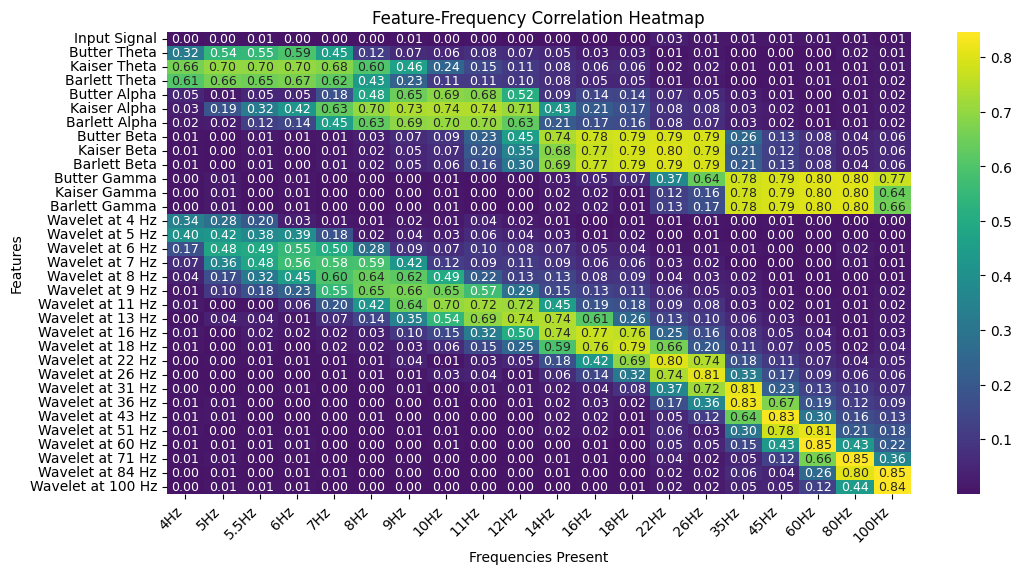

In [ ]:



def plot_correlation_heatmap(correlation_matrix):
    """
    Plots a heatmap of the feature-frequency correlation matrix.

    :param correlation_matrix: np.array of shape (25, 20) - Correlation values between features and frequencies.
    """
    plt.figure(figsize=(12, 6))
    sns.heatmap(abs(correlattion_table), annot=True, fmt=".2f", cmap="viridis", center=0.4,
                xticklabels=[f"{i}Hz" for i in mean_freqs_manual],
                yticklabels=feature_names,
                annot_kws={"size": 9})
    plt.title("Feature-Frequency Correlation Heatmap")
    plt.xlabel("Frequencies Present")
    plt.xticks(rotation=45, ha='right')
    plt.ylabel("Features")
    plt.show()

# Plot the correlation heatmap
plot_correlation_heatmap(correlation_table)

In [ ]:
# Test: Print part of the updated data
print("Original values:", burst_label_vec[0, 10, 0, 50:100])
print("5 classes values:", label_vec_5class[0, 10, 0, 50:100])
print("Binary classes values:", label_vec_binary[0, 10, 0, 50:100])

Original values: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
5 classes values: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0]
Binary classes values: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0]


In [ ]:
## Class distribution
unique, counts = np.unique(label_vec_5class.flatten(), return_counts=True)
print(f"Class distribution: {dict(zip(unique, counts))}")
print(f"Noise  Percentage: {(counts[0]/(sum(counts))):.4f}")
print(f"Theta Percentage: {(counts[1]/(sum(counts))):.4f}")
print(f"Alpha Percentage: {(counts[2]/(sum(counts))):.4f}")
print(f"Beta Percentage: {(counts[3]/(sum(counts))):.4f}")
print(f"Gamma Percentage: {(counts[4]/(sum(counts))):.4f}")

Class distribution: {0: 4008043, 1: 882021, 2: 882177, 3: 886981, 4: 840778}
Noise  Percentage: 0.5344
Theta Percentage: 0.1176
Alpha Percentage: 0.1176
Beta Percentage: 0.1183
Gamma Percentage: 0.1121


In [ ]:
feature_vec_32 = feature_vec.astype(np.float32)

print(feature_vec_32.flatten()[-20:])
print(feature_vec.flatten()[-20:])

[0.02019627 0.02884918 0.01426663 0.0042882  0.01726151 0.02770652
 0.0418342  0.04594816 0.03067602 0.03158105 0.03082464 0.01898638
 0.00819133 0.03088152 0.04524539 0.03591428 0.01651429 0.01389179
 0.02477201 0.02697503]
[0.02019627 0.02884918 0.01426663 0.0042882  0.01726151 0.02770652
 0.0418342  0.04594815 0.03067602 0.03158105 0.03082464 0.01898638
 0.00819133 0.03088152 0.04524539 0.03591428 0.01651429 0.01389179
 0.02477201 0.02697503]


In [ ]:
du.data_info(feature_vec)

DATASET INFO:
Shape: (10, 20, 5, 7500, 25)

No of Samples: 10

No of Frequencies: 20
Freqency values: [4, 5, 6, 7, 8, 9, 11, 13, 16, 18, 22, 26, 31, 36, 43, 51, 60, 71, 84, 100]

No of noise ratios: 5
Signal to Noise ratios (in db) [-10, -8, -6, -4, -2, 0, 2, 4, 6, 8]

No of Datapoints: 7500

No of Features per Datapoint: 25 (signal, hilbert amp, 20 wavelets for each freq)


In [ ]:
hilbert_feature_vec = feature_vec_32[:,:,:,:,:5]

In [ ]:
print(hilbert_feature_vec.shape)
print(feature_vec.shape)

NameError: name 'hilbert_feature_vec' is not defined

6


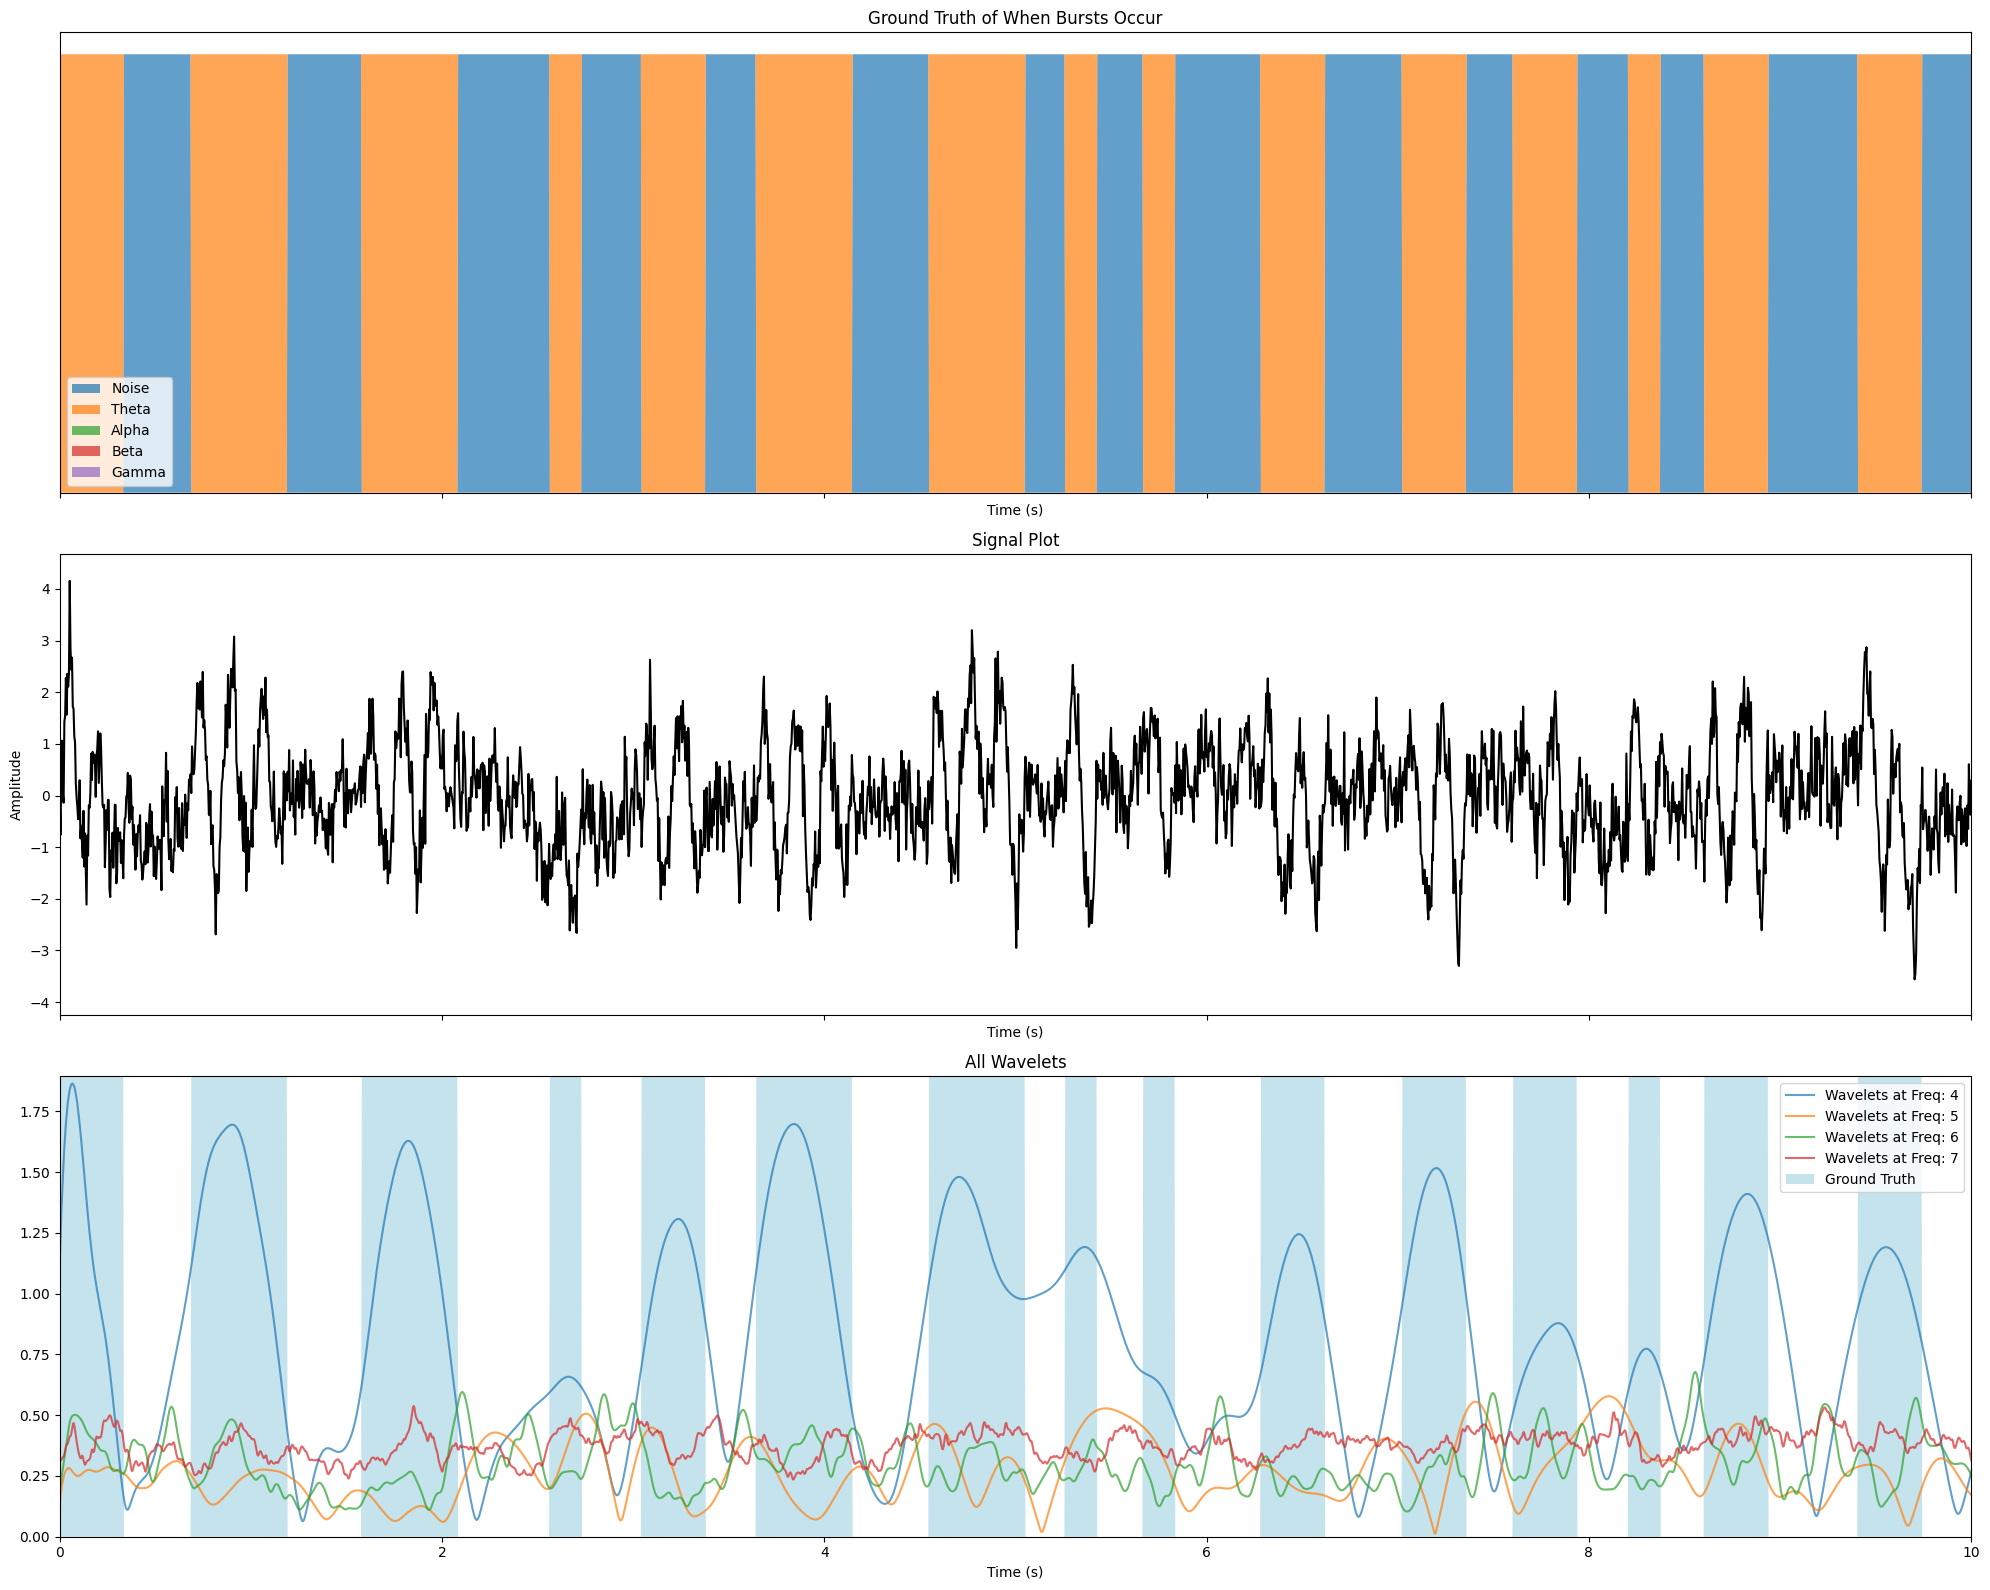

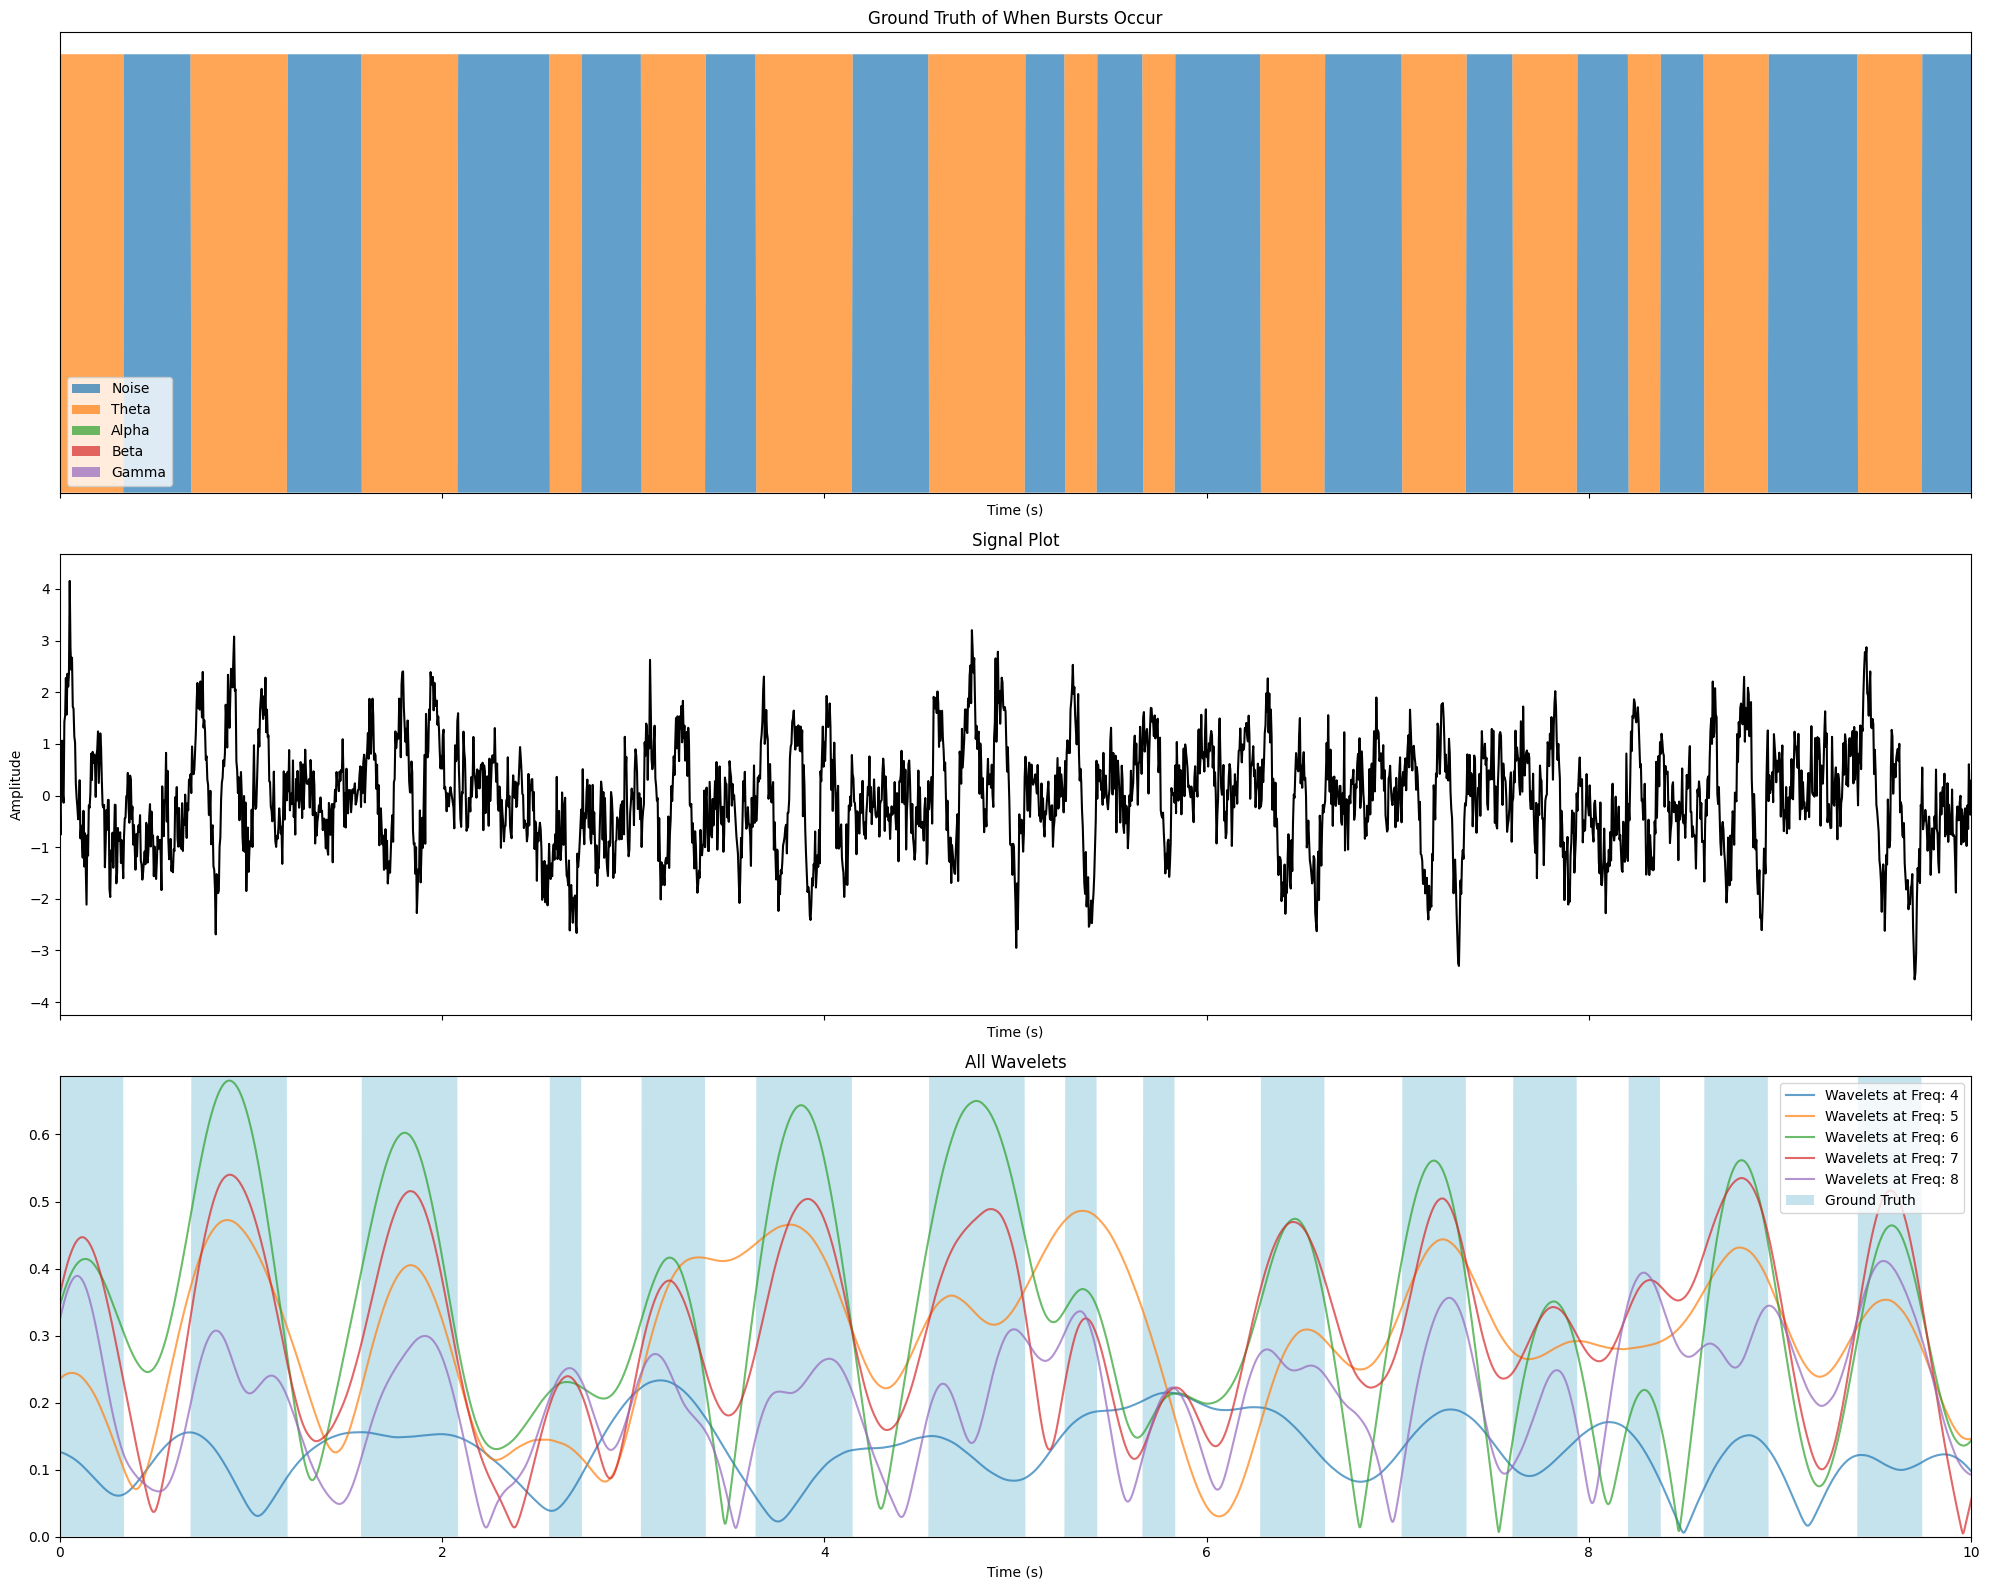

In [ ]:
noise = 2
freq = 3

label_sample = label_vec_5class[0, freq, noise, :]
signal_sample = feature_vec[0, freq, noise, :, 0]
feature_sample = feature_vec[0, freq, noise, :, 1:5]
wavelet_sample = feature_vec[0, freq, noise, :, -20:-15]

print(mean_freqs_manual[freq])
du.visualize_feature_data(label_sample, signal_sample, feature_sample,
                          sampling_frequency=250, duration=30,
                          time_window=(0, 10), category_labels=["Noise","Theta","Alpha","Beta","Gamma"])

du.visualize_feature_data(label_sample, signal_sample, wavelet_sample,
                          sampling_frequency=250, duration=30,
                          time_window=(0, 10), category_labels=["Noise", "Theta","Alpha","Beta","Gamma"])

In [ ]:
feature_vec.shape

(10, 20, 5, 7500, 25)

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def feature_category_correlation(feature_data, label_data, category_names):
    """
    Calculates the correlation between features and categories and displays it in a table.

    Args:
        feature_data (np.ndarray): Feature data of shape (N, F) where N is the number of samples and F is the number of features.
        label_data (np.ndarray): Label data of shape (N, 5) where 5 represents the 5 categories.
        category_names (list): List of category names (e.g., ['Noise', 'Theta', 'Alpha', 'Beta', 'Gamma']).

    Returns:
        pd.DataFrame: A Pandas DataFrame containing the correlation matrix.
    """
    # Reshape label_data to 2D if it has more than 2 dimensions
    label_data = label_data.reshape(-1, label_data.shape[-1])
    # Reshape feature_data to 2D to match label_data
    feature_data = feature_data.reshape(-1, feature_data.shape[-1])

    num_features = feature_data.shape[1]
    num_categories = label_data.shape[1]

    correlation_matrix = np.zeros((num_features, num_categories))

    for feature_idx in range(num_features):
        for category_idx in range(num_categories):
            correlation_matrix[feature_idx, category_idx] = np.corrcoef(
                feature_data[:, feature_idx], label_data[:, category_idx]
            )[0, 1]  # Get the correlation coefficient

    # Create a Pandas DataFrame for the table
    correlation_df = pd.DataFrame(correlation_matrix,
                                  index=[f"Feature {i}" for i in range(num_features)],
                                  columns=category_names)

    return correlation_df

# Example usage:
category_names = ['Noise', 'Theta', 'Alpha', 'Beta', 'Gamma']

data_vec = feature_vec[0].reshape(-1, feature_vec.shape[-1])
label_sample_vec = label_vec_5class[0].flatten()

label_sample_vec = du.one_hot_encode_single_sample(label_sample_vec, categories=[0,1,2,3,4])

correlation_table = feature_category_correlation(data_vec, label_vec_5class, category_names)

ValueError: all the input array dimensions except for the concatenation axis must match exactly, but along dimension 1, the array at index 0 has size 750000 and the array at index 1 has size 1000

In [ ]:
# Create custom y-axis labels
feature_names = ['Input Signal'] + \
                [f'Hilbert Amp {freq}' for freq in category_names[1:]] + \
                [f'Wavelet at {freq} Hz' for freq in mean_freqs_round]


# Display the correlation table as a heatmap
plt.figure(figsize=(10, 6))  # Adjust figure size as needed
sns.heatmap(correlation_table, annot=True, cmap="viridis", fmt=".2f",
            yticklabels=feature_names)  # Use custom yticklabels
plt.title("Feature-Category Correlation")
plt.xlabel("Categories")
plt.ylabel("Features")
plt.show()

In [ ]:
print("The given array is:",feature_vec.shape)
print("The size of array arr is:",feature_vec.size)
print("The memorysize of each element of arr is:", feature_vec.itemsize,"bytes")
print("The memory size of feature vec (float64) arr is:", round((feature_vec.itemsize * feature_vec.size) / (1024 * 1024), 2), "MB")
print("The memory size of feature vec (float32) arr is:", round((feature_vec_32.itemsize * feature_vec_32.size) / (1024 * 1024), 2), "MB")

print("The memory size of label vec arr is:", round((label_vec_5class.itemsize * label_vec_5class.size) / (1024 * 1024), 2), "MB")

The given array is: (10, 20, 5, 7500, 25)
The size of array arr is: 187500000
The memorysize of each element of arr is: 8 bytes
The memory size of feature vec (float64) arr is: 1430.51 MB
The memory size of feature vec (float32) arr is: 715.26 MB
The memory size of label vec arr is: 57.22 MB


In [ ]:
base_path = "/content/drive/MyDrive/Colab Notebooks/Bachelor Thesis/Data/Including Features/"

# saves the large training vector with the wavelet and hilbert amplitude features
np.save(f"{base_path}5_class_mid_noise_30s_features_vec.npy", feature_vec_32)

# saves a smaller training vector with the wavelet and hilbert amplitude features
np.save(f"{base_path}5_class_mid_noise_30s_hilbert_feature_vec.npy", hilbert_feature_vec)

# saves the numeric labels (0,...,4) for ML Task
np.save(f"{base_path}5_class_mid_noise_30s_numeric_label_vec.npy", label_vec_5class)

# saves the numeric labels as binary for ML Task
np.save(f"{base_path}2_class_mid_noise_30s_numeric_label_vec.npy", label_vec_binary)

In [ ]:
mean_freqs_manual = [4, 5, 5.5, 6, 7, 8, 9, 10, 11, 12, 14, 16, 18, 22, 26, 30, 45, 60, 80, 100]

In [ ]:
mean_freqs_manual[10:15]

[14, 16, 18, 22, 26]

## Feature Visualization with Signal

In [ ]:
# Get the current working directory (where your notebook is)
current_directory = os.getcwd()

# Construct the full path to your data_utils.py file
data_utils_path = '/content/drive/MyDrive/Colab Notebooks/Bachelor Thesis/Thesis Files/'  # Replace with the actual path

# Add the directory containing data_utils.py to the Python path
sys.path.append(os.path.dirname(data_utils_path))  # Add parent directory of data_utils.py

# Now you can import the custom module
import data_utils as du
import analysis_utils as au

sys.path = []

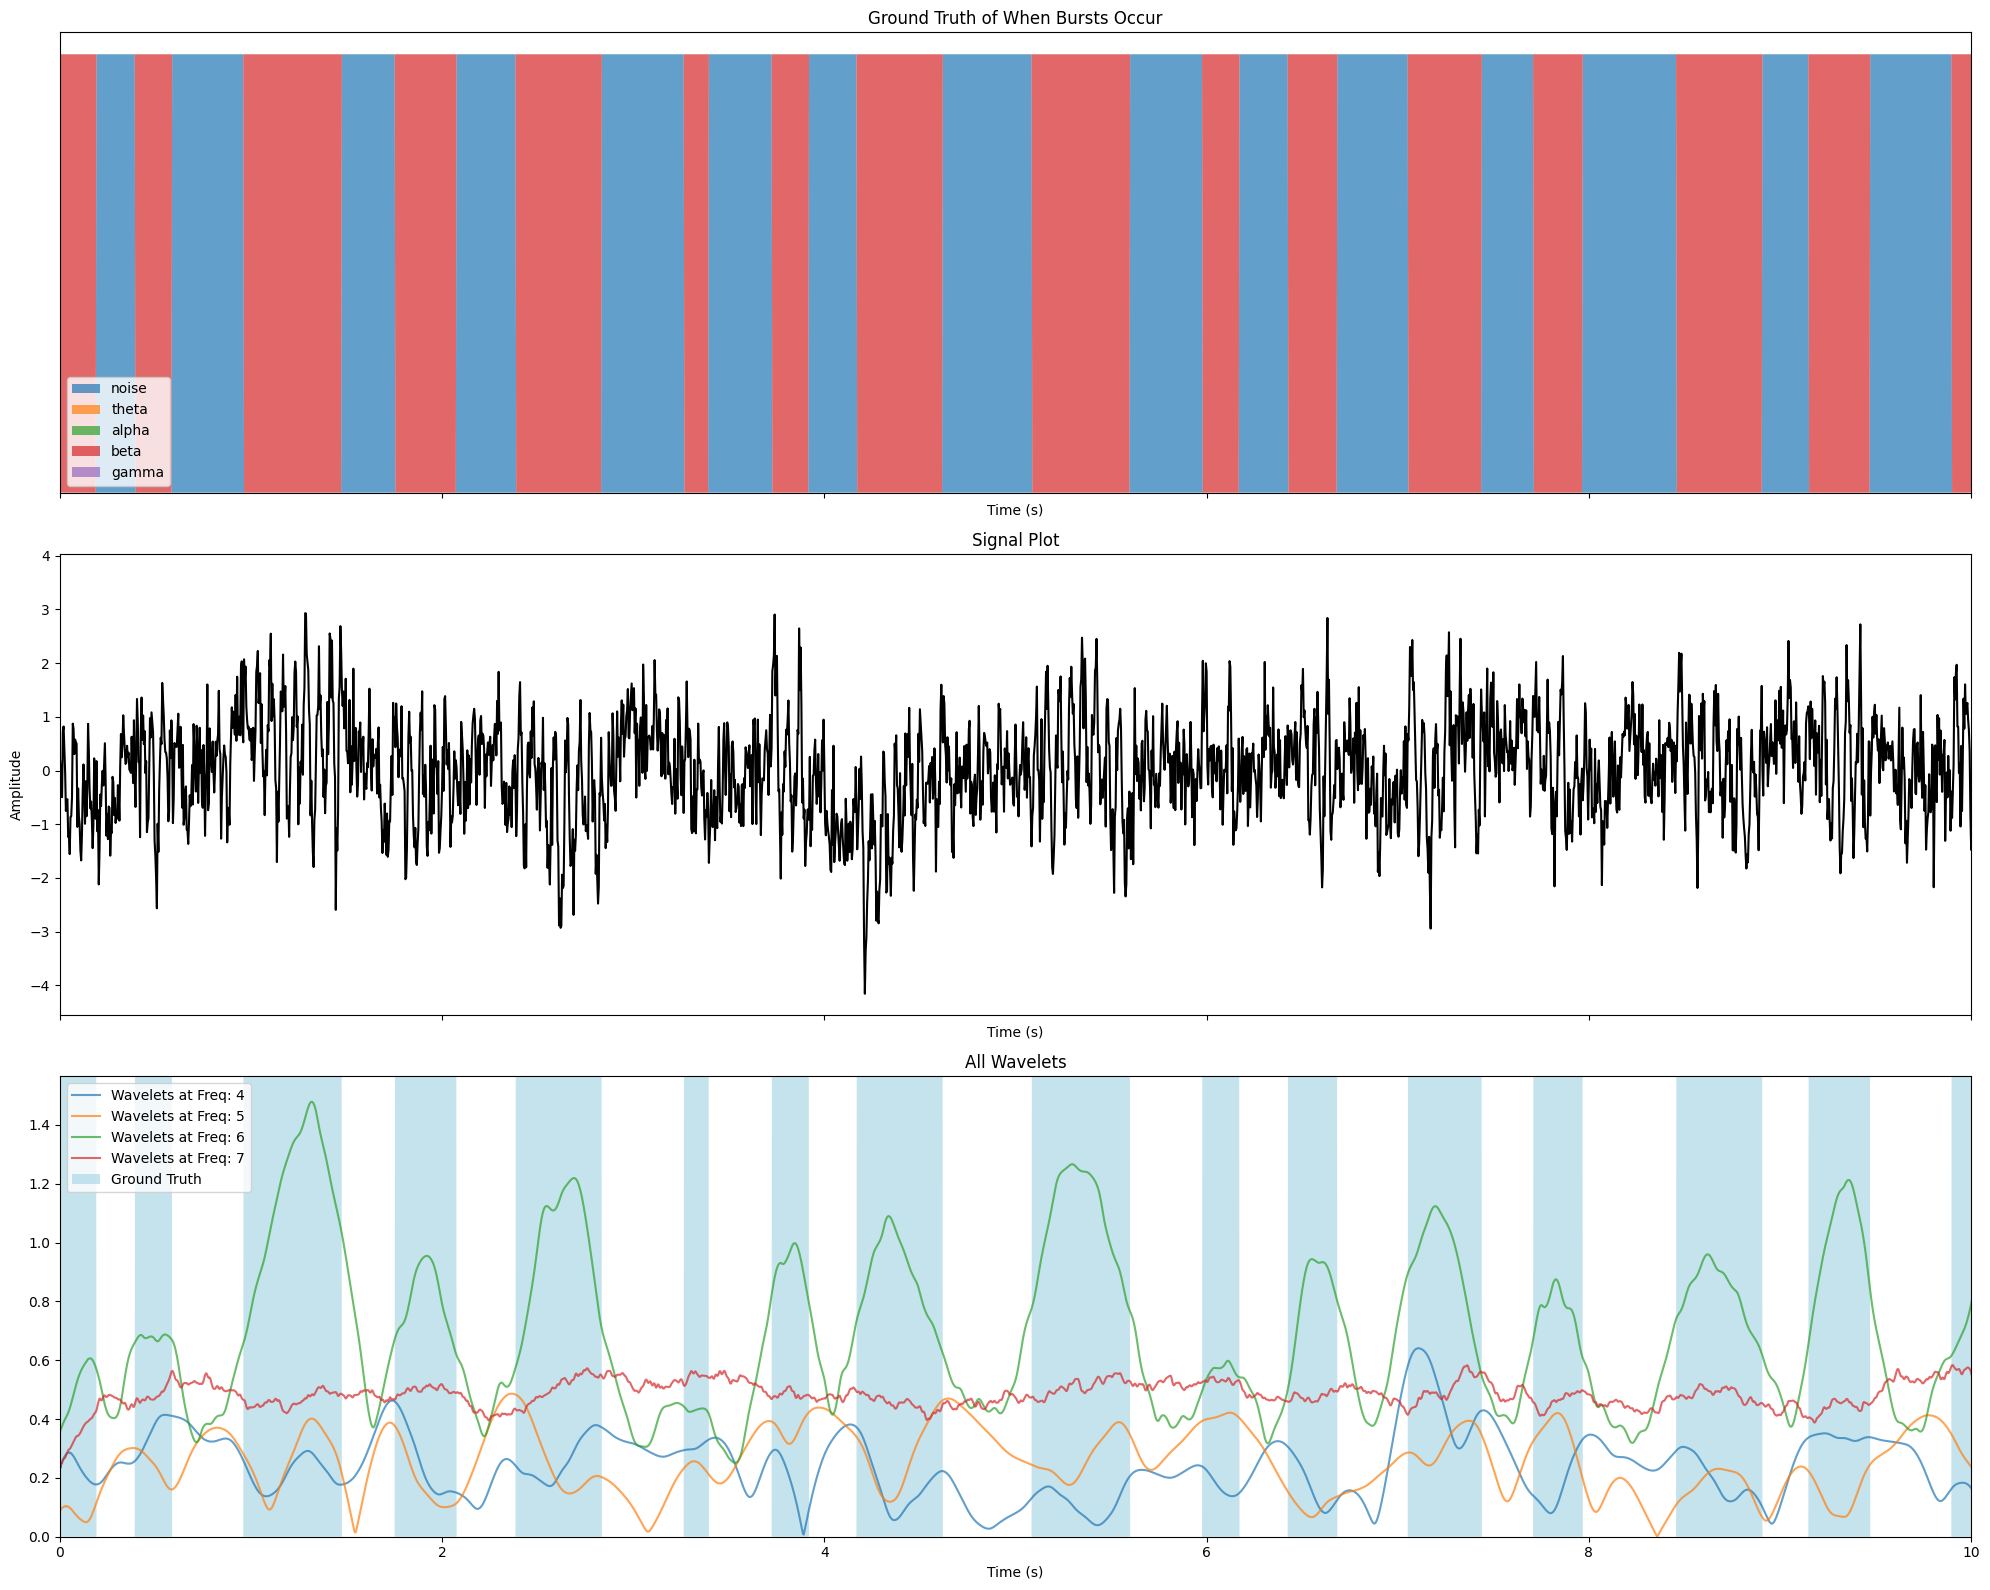

In [ ]:
# [4, 5, 6, 7, 8, 9, 11, 13, 16, 18, 22, 26, 31, 36, 43, 51, 60, 71, 84, 100]

first_edge= (3,4) # 7, 8 Hz
second_edge = (6,7) # 11, 13 Hz
third_edge = (11, 12) # 26, 31 Hz

sample_id = 0
freq_id = 11


snr_id = 1
category_labels=['noise', 'theta', 'alpha', 'beta', 'gamma']

signal_sample = feature_vec[sample_id,freq_id,snr_id,:,0]
wavelet_sample = feature_vec[sample_id,freq_id,snr_id,:,1:5]
label_sample = label_vec_5class[sample_id,freq_id,snr_id,:]

visualize_feature_data(label_sample, signal_sample, wavelet_sample, duration=30, time_window=(0, 10),
                       category_labels=category_labels)

In [ ]:
feature_vec_32.shape

(10, 20, 5, 7500, 25)

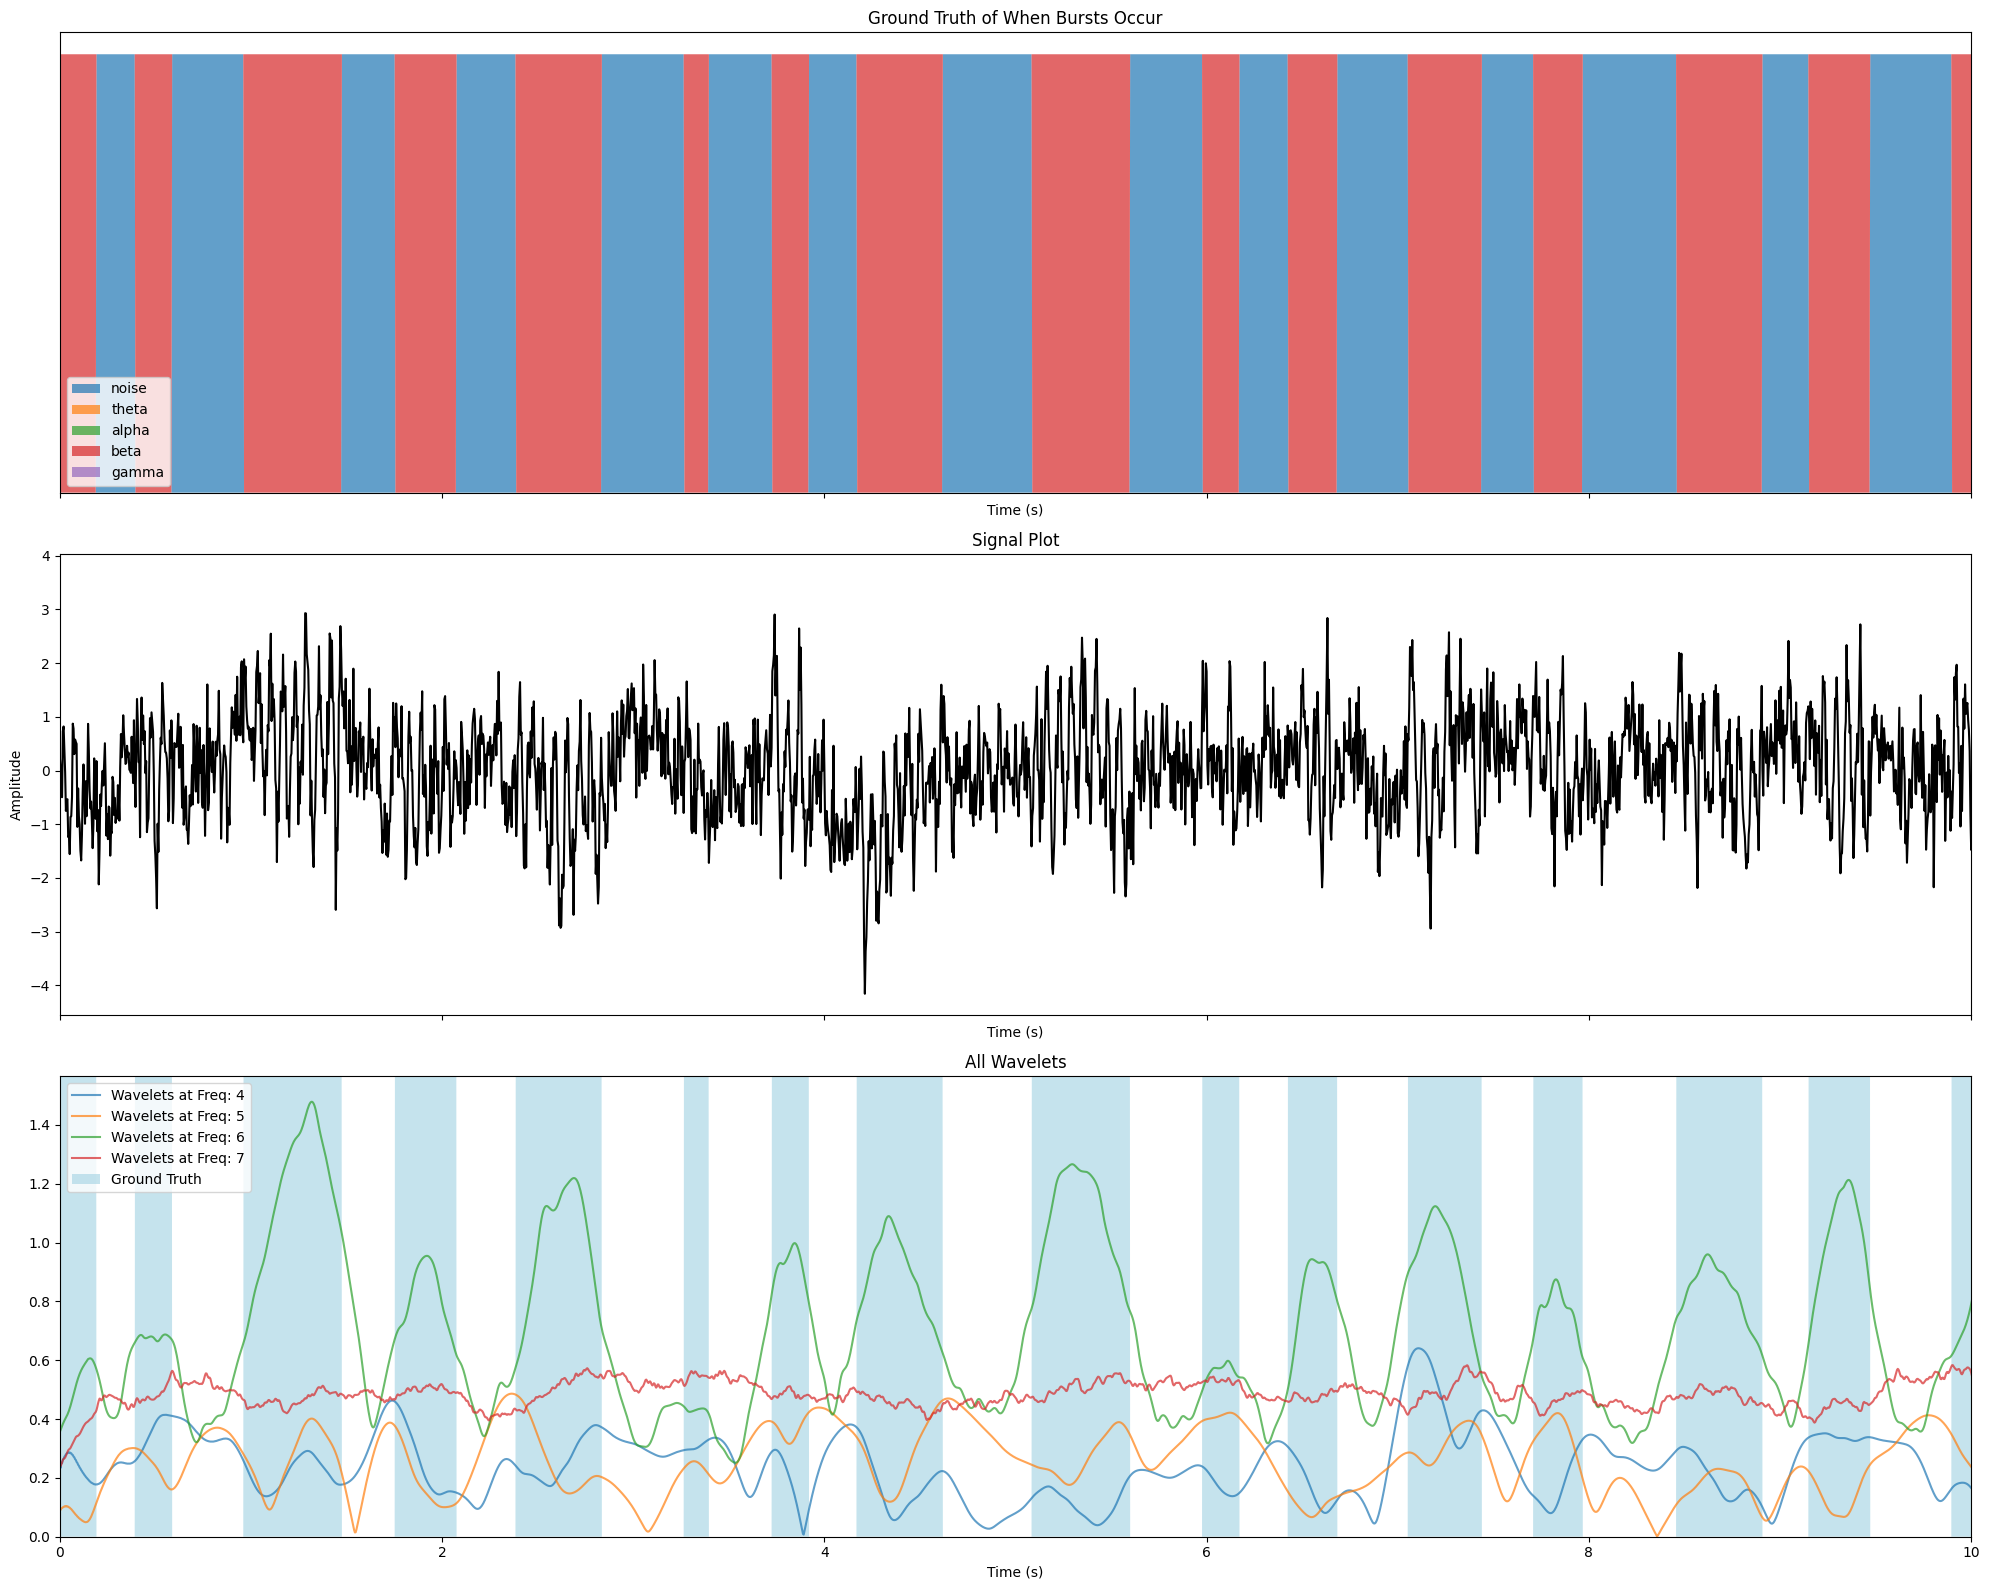

In [ ]:
signal_sample = feature_vec_32[sample_id,freq_id,snr_id,:,0]
wavelet_sample = feature_vec_32[sample_id,freq_id,snr_id,:,1:5]
label_sample = label_vec_5class[sample_id,freq_id,snr_id,:]

visualize_feature_data(label_sample, signal_sample, wavelet_sample, duration=30, time_window=(0, 10),
                       category_labels=category_labels)

In [ ]:
def visualize_feature_data(label_sample, signal_sample, feature_sample, sampling_frequency=250, duration=60, time_window=(0, 10), category_labels=None):
    """
    Visualizes feature data (Hilbert Amplitude & Wavelets) with ground truth labels and signal plot.

    Args:
        label_sample (np.ndarray): 1D array of ground truth labels.
        signal_sample (np.ndarray): 1D array of signal data.
        feature_sample (np.ndarray): 2D array of feature data. (sequence_len, num_features)
        sampling_frequency (int, optional): Sampling frequency of the data. Defaults to 250.
        duration (int, optional): Duration of the data in seconds. Defaults to 60.
        time_window (tuple, optional): Time window to display in seconds (start, end). Defaults to (0, 10).
        category_labels (list, optional): Labels for the categories in the stackplot. Defaults to ['noise', 'beta'].
    """

    time_vec = np.linspace(0, duration, duration * sampling_frequency, endpoint=False)

    num_features = feature_sample.shape[1]

    fig, ax = plt.subplots(3, 1, figsize=(20, 16), sharex=True)

    if category_labels is not None:
        unique_label_list = list(range(len(category_labels)))
        # Create a one-hot encoded matrix for stackplot
        one_hot_label_sample = du.one_hot_encode_single_sample(label_sample, categories=unique_label_list)  # Use unique labels for categories
    else:
        one_hot_label_sample = du.one_hot_encode_single_sample(label_sample, categories=np.unique(category_labels))  # Use unique labels for categories

    # Visualizing burst labels as colors
    ax[0].stackplot(time_vec, one_hot_label_sample.T, labels=category_labels, alpha=0.7)  # Adjust labels based on categories
    ax[0].set_xlabel("Time (s)")
    ax[0].set_yticks([])  # y-axis does not mean anything
    ax[0].set_title("Ground Truth of When Bursts Occur")
    ax[0].legend()

    # the period of blue: bursts
    ax[1].plot(time_vec, signal_sample, color="k")
    ax[1].set_xlabel("Time (s)")
    ax[1].set_ylabel("Amplitude")
    ax[1].set_title("Signal Plot")

    # Plot LFP signal
    for feature_idx in range(num_features):
      if num_features == 1:
          ax[2].plot(time_vec, feature_sample[:, feature_idx], alpha=0.7, label='Hilbert Amplitdue')
          ax[2].set_title(f"Hilbert Amplitude")
      else:
          # These will determine for what freq band the wavelet is adjusted
          mean_freqs = np.logspace(np.log10(4), np.log10(100), num=20)
          mean_freqs_round = np.round(mean_freqs).astype(int)
          ax[2].plot(time_vec, feature_sample[:, feature_idx], alpha=0.7, label=f'Wavelets at Freq: {mean_freqs_round[feature_idx]}')
          ax[2].set_title(f"All Wavelets")
    # Overall maximum
    max_value = np.max(feature_sample)
    ax[2].stackplot(time_vec, label_sample*max_value, labels=["Ground Truth"], alpha=0.7, colors=['lightblue'])
    ax[2].set_xlabel("Time (s)")
    ax[2].legend()
    ax[2].set_xlim(time_window)
    ax[2].set_ylim(0, max_value)

    plt.xlim(time_window[0], time_window[1])
    plt.tight_layout()
    plt.show()

I have been experimenting with different smooothin settings for the amplitude envelopes seen above.

The higher the frequencies the more smoothing was necessary.

The choice of a butter band-pass filter is one specific one in itself.

I will play with the butter band pass **order** that way I may get more granular results. Especially with a lower order.

What I did:
- Butter Band-Pass Filter
- Increasing values per freq band:
  - Order for band-pass
  - smoothing factor

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import welch

def plot_power_spectra(training_data, fs=250):
    """
    Plots power spectra for each noise level (5 levels), with overlays of 3 sample signals per noise index.

    :param training_data: Training dataset of shape (5, 20, 5, 7500, F)
    :param fs: Sampling frequency
    """
    noise_levels = [0, 1, 2, 3, 4]  # Indices for different noise levels
    sample_indices = [0, 2, 4]  # Select 3 noise level samples to overlay
    fig, axes = plt.subplots(1, 5, figsize=(20, 4), sharey=True)

    for i, noise_idx in enumerate(noise_levels):
        ax = axes[i]
        ax.set_title(f"Noise Level {noise_idx}")

        # Compute mean power spectrum over all samples at this noise level
        mean_psd = np.zeros(129)  # Assuming 129 frequency bins from Welch
        for j in range(training_data.shape[1]):  # Iterate over frequency bands
            freqs, psd = welch(training_data[noise_idx, j, :, :, 0], fs=fs, nperseg=256)
            mean_psd += np.mean(psd, axis=0)
        mean_psd /= training_data.shape[1]  # Average over bands

        ax.plot(freqs, mean_psd, color='black', label="Mean Spectrum", linewidth=2)

        # Overlay individual samples (High, Mid, Low Noise)
        for sample in sample_indices:
            _, sample_psd = welch(training_data[noise_idx, 0, sample, :, 0], fs=fs, nperseg=256)
            ax.plot(freqs, sample_psd, alpha=0.6, linestyle='dashed')

        ax.set_xscale("log")
        ax.set_yscale("log")
        ax.set_xlabel("Frequency (Hz)")
        if i == 0:
            ax.set_ylabel("Power")

    plt.tight_layout()
    plt.show()

# Example usage:
# plot_power_spectra(training_data)


In [ ]:
import neurodsp.timefrequency as tf
import seaborn as sns

def plot_wavelet_summary(training_data, fs=250, freqs=[4, 8, 12, 30, 50]):
    """
    Plots wavelet transforms for different noise levels as a stacked heatmap.

    :param training_data: Training dataset of shape (5, 20, 5, 7500, F)
    :param fs: Sampling frequency
    :param freqs: Selected frequency bands for wavelet decomposition
    """
    fig, axes = plt.subplots(3, 1, figsize=(12, 9), sharex=True, sharey=True)

    noise_levels = [0, 2, 4]  # Low, mid, high noise
    for i, noise_idx in enumerate(noise_levels):
        sig = training_data[noise_idx, 0, 0, :, 0]  # Take 1 sample from noise level
        power = tf.compute_wavelet_transform(sig, fs, freqs)

        sns.heatmap(power, ax=axes[i], cmap="magma", cbar=False)
        axes[i].set_title(f"Wavelet Transform - Noise Level {noise_idx}")

    plt.xlabel("Time")
    plt.ylabel("Frequency Bands")
    plt.tight_layout()
    plt.show()

# Example usage:
# plot_wavelet_summary(training_data)


In [ ]:
def plot_hilbert_summary(training_data):
    """
    Plots the mean and variance of Hilbert envelopes across different noise levels.

    :param training_data: Training dataset of shape (5, 20, 5, 7500, F)
    """
    noise_levels = [0, 2, 4]
    fig, ax = plt.subplots(figsize=(10, 5))

    for noise_idx in noise_levels:
        mean_env = np.mean(training_data[noise_idx, :, :, :, 0], axis=(0, 1))
        std_env = np.std(training_data[noise_idx, :, :, :, 0], axis=(0, 1))
        ax.plot(mean_env, label=f"Noise Level {noise_idx}")
        ax.fill_between(range(len(mean_env)), mean_env - std_env, mean_env + std_env, alpha=0.2)

    ax.set_title("Hilbert Envelope - Mean & Variance Across Noise Levels")
    ax.set_xlabel("Time")
    ax.set_ylabel("Amplitude")
    ax.legend()
    plt.show()

# Example usage:
# plot_hilbert_summary(training_data)
